Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5746c000 @  0x7fdebacde2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
!wget https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true -O dataset.hdf5

--2019-01-09 00:13:00--  https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5 [following]
--2019-01-09 00:13:00--  https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5 [following]
--2019-01-09 00:13:00--  https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connecte

In [0]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [0]:
import torch
import torch.nn as nn

# https://github.com/pytorch/examples/blob/master/dcgan/main.py

image_shape = (4, 28, 28)
latent_shape = (100, 1, 1)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)


# Generator
G = nn.Sequential(
        # ConvTranspose2d: next width or height := (prev_height - 1) * stride + kernel_size - padding * 2
        # Conv2d: next width or height := (prev + 2 * padding - kernel_size) // stride + 1

        # https://distill.pub/2016/deconv-checkerboard/

        # Shape: 100 x 1 x 1
        nn.ConvTranspose2d(100, 1024, kernel_size=7, stride=1, padding=0),
        nn.ReLU(True),
        nn.BatchNorm2d(1024), # nn.utils.SpectralNorm(),
        # Shape: 1024 x 7 x 7
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(512), # nn.utils.SpectralNorm(),
        # Shape: 512 x 14 x 14
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(256), # nn.utils.SpectralNorm(),
        # Shape: 256 x 28 x 28
        nn.ConvTranspose2d(256, 4, kernel_size=5, stride=1, padding=2),
        nn.Tanh()
        # Shape: 4 x 28 x 28
)

# Discriminator
D = nn.Sequential(
        # Shape: 4 x 28 x 28
        nn.Conv2d(4, 256, kernel_size=5, stride=1, padding=2),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(256),
        #nn.Dropout(0.2),
        # Shape: 256 x 28 x 28
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(512),
        #nn.Dropout(0.2),
        # Shape: 512 x 14 x 14
        nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1), # => batch, 512, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(1024),
        #nn.Dropout(0.2),
        # Shape: 1024 x 7 x 7
        nn.Conv2d(1024, 1, kernel_size=7, stride=1, padding=0), # => batch, 1024, 7, 7
        #nn.Sigmoid()
        # Shape: 1 x 1 x 1
)


# Binary cross entropy loss and optimizer
#criterion = nn.BCELoss()
d_optimizer = torch.optim.RMSprop(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=0.0002)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(123, *latent_shape))
assert(g_out.size() == torch.randn(123, *image_shape).size())
print("DISCRIMINATOR")
d_out = D(g_out)
assert(d_out.size() == torch.randn(123, *((1,)*len(image_shape))).size())
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
ConvTranspose2d:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 1024, 7, 7])
ReLU:  torch.Size([123, 1024, 7, 7]) => torch.Size([123, 1024, 7, 7])
BatchNorm2d:  torch.Size([123, 1024, 7, 7]) => torch.Size([123, 1024, 7, 7])
ConvTranspose2d:  torch.Size([123, 1024, 7, 7]) => torch.Size([123, 512, 14, 14])
ReLU:  torch.Size([123, 512, 14, 14]) => torch.Size([123, 512, 14, 14])
BatchNorm2d:  torch.Size([123, 512, 14, 14]) => torch.Size([123, 512, 14, 14])
ConvTranspose2d:  torch.Size([123, 512, 14, 14]) => torch.Size([123, 256, 28, 28])
ReLU:  torch.Size([123, 256, 28, 28]) => torch.Size([123, 256, 28, 28])
BatchNorm2d:  torch.Size([123, 256, 28, 28]) => torch.Size([123, 256, 28, 28])
ConvTranspose2d:  torch.Size([123, 256, 28, 28]) => torch.Size([123, 4, 28, 28])
Tanh:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 4, 28, 28])
Sequential:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 4, 28, 28])
DISCRIMINATOR
Conv2d:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 2

In [0]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.tensor(np.moveaxis(dataset[:50000], 3, 1)/128 - 1, dtype=torch.float).to(device)
    print(preloaded_data[100][3][10])
    print(preloaded_data.size())

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def tensor2plt(img):
    return denorm(img[[2,1,0,3],:,:].permute(1,2,0))


tensor([ 0.4688,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.8750, -0.5312], device='cuda:0')
torch.Size([50000, 4, 28, 28])


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    for image in dataset[:1]:
        plt.figure()
        plt.imshow(image[:,:,[2,1,0,3]])
        plt.show()

# Output first few real images
for image in preloaded_data[:1].cpu():
    plt.figure()
    plt.imshow(tensor2plt(image))
    plt.show()

Epoch [0/50], Step [1/390], d_loss: 0.8935, g_loss: 0.0459, D(x): 0.09, D(G(z)): 0.98
Epoch [0/50], Step [2/390], d_loss: -0.1274, g_loss: -0.0280, D(x): 0.16, D(G(z)): 0.03
Epoch [0/50], Step [3/390], d_loss: -0.1196, g_loss: -0.0684, D(x): 0.19, D(G(z)): 0.07
Epoch [0/50], Step [4/390], d_loss: -0.0894, g_loss: -0.1009, D(x): 0.19, D(G(z)): 0.10
Epoch [0/50], Step [5/390], d_loss: -0.0534, g_loss: -0.1217, D(x): 0.18, D(G(z)): 0.12
Epoch [0/50], Step [6/390], d_loss: -0.0499, g_loss: -0.1358, D(x): 0.19, D(G(z)): 0.14
Epoch [0/50], Step [7/390], d_loss: -0.0258, g_loss: -0.1559, D(x): 0.19, D(G(z)): 0.16
Epoch [0/50], Step [8/390], d_loss: -0.0448, g_loss: -0.1613, D(x): 0.21, D(G(z)): 0.17
Epoch [0/50], Step [9/390], d_loss: -0.0196, g_loss: -0.1710, D(x): 0.20, D(G(z)): 0.18
Epoch [0/50], Step [10/390], d_loss: 0.0028, g_loss: -0.1767, D(x): 0.18, D(G(z)): 0.19
Epoch [0/50], Step [11/390], d_loss: -0.0087, g_loss: -0.1773, D(x): 0.19, D(G(z)): 0.19
Epoch [0/50], Step [12/390], d_lo

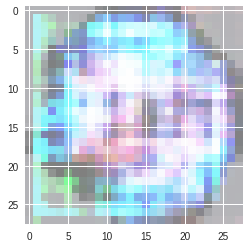

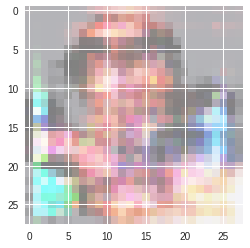

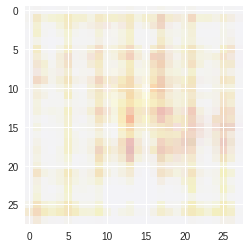

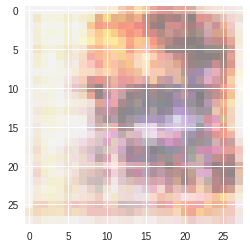

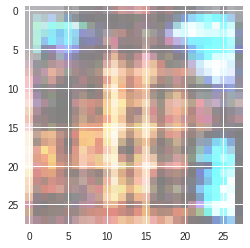

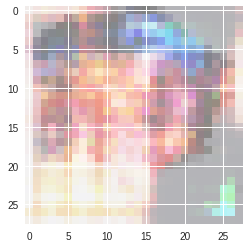

Epoch [1/50], Step [1/390], d_loss: -0.1273, g_loss: 0.6144, D(x): -0.06, D(G(z)): -0.18
Epoch [1/50], Step [2/390], d_loss: -0.2304, g_loss: 0.3115, D(x): -0.30, D(G(z)): -0.53
Epoch [1/50], Step [3/390], d_loss: -0.0553, g_loss: 0.1820, D(x): -0.01, D(G(z)): -0.07
Epoch [1/50], Step [4/390], d_loss: -0.1922, g_loss: 0.3754, D(x): 0.07, D(G(z)): -0.12
Epoch [1/50], Step [5/390], d_loss: -0.1505, g_loss: 0.3418, D(x): -0.15, D(G(z)): -0.30
Epoch [1/50], Step [6/390], d_loss: -0.1406, g_loss: 0.7026, D(x): -0.11, D(G(z)): -0.25
Epoch [1/50], Step [7/390], d_loss: -0.1802, g_loss: 0.4254, D(x): -0.45, D(G(z)): -0.63
Epoch [1/50], Step [8/390], d_loss: -0.1976, g_loss: 0.7312, D(x): -0.10, D(G(z)): -0.30
Epoch [1/50], Step [9/390], d_loss: -0.2249, g_loss: 0.0731, D(x): -0.39, D(G(z)): -0.61
Epoch [1/50], Step [10/390], d_loss: 0.1311, g_loss: 0.0492, D(x): 0.10, D(G(z)): 0.23
Epoch [1/50], Step [11/390], d_loss: 0.0508, g_loss: 0.1896, D(x): 0.02, D(G(z)): 0.07
Epoch [1/50], Step [12/390

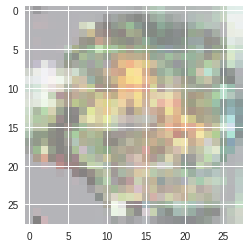

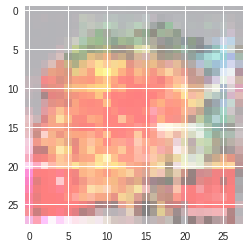

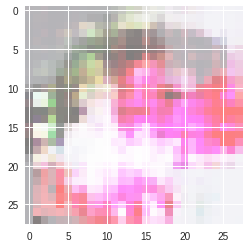

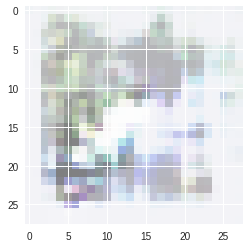

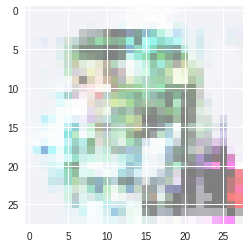

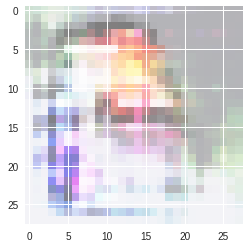

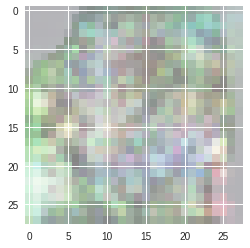

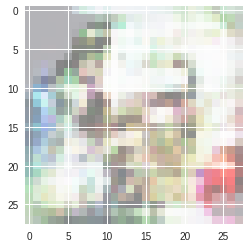

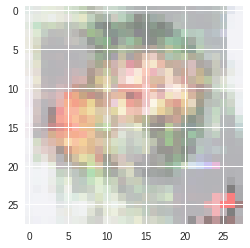

Epoch [2/50], Step [1/390], d_loss: -0.6597, g_loss: 1.7738, D(x): 1.52, D(G(z)): 0.86
Epoch [2/50], Step [2/390], d_loss: -1.4590, g_loss: 2.2203, D(x): 0.46, D(G(z)): -1.00
Epoch [2/50], Step [3/390], d_loss: -1.0527, g_loss: -0.0985, D(x): -0.43, D(G(z)): -1.49
Epoch [2/50], Step [4/390], d_loss: -1.5583, g_loss: 2.7485, D(x): 1.83, D(G(z)): 0.27
Epoch [2/50], Step [5/390], d_loss: -1.6933, g_loss: -0.1280, D(x): -0.34, D(G(z)): -2.03
Epoch [2/50], Step [6/390], d_loss: -1.6921, g_loss: 2.9217, D(x): 1.85, D(G(z)): 0.16
Epoch [2/50], Step [7/390], d_loss: -1.0681, g_loss: 0.8632, D(x): -1.65, D(G(z)): -2.72
Epoch [2/50], Step [8/390], d_loss: -0.8289, g_loss: 2.0065, D(x): 0.83, D(G(z)): -0.00
Epoch [2/50], Step [9/390], d_loss: -1.2487, g_loss: 1.3584, D(x): -0.10, D(G(z)): -1.35
Epoch [2/50], Step [10/390], d_loss: -1.7109, g_loss: 0.4041, D(x): 0.32, D(G(z)): -1.39
Epoch [2/50], Step [11/390], d_loss: -0.7866, g_loss: 2.5679, D(x): 1.56, D(G(z)): 0.78
Epoch [2/50], Step [12/390],

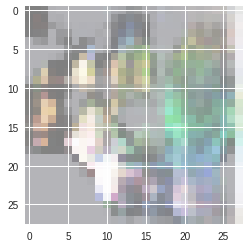

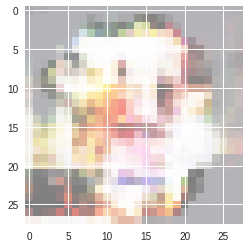

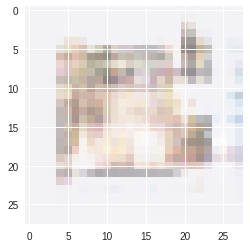

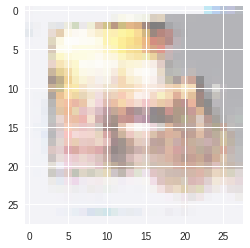

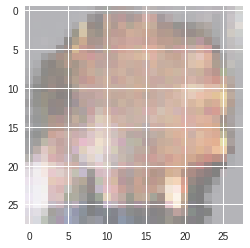

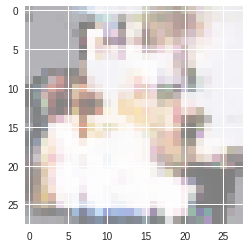

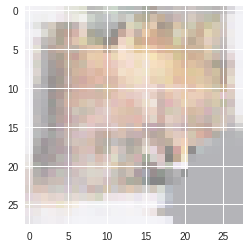

Epoch [3/50], Step [1/390], d_loss: -3.7024, g_loss: 2.7904, D(x): 2.55, D(G(z)): -1.16
Epoch [3/50], Step [2/390], d_loss: -2.5227, g_loss: 0.6200, D(x): 0.36, D(G(z)): -2.16
Epoch [3/50], Step [3/390], d_loss: -3.5511, g_loss: 2.6009, D(x): 2.58, D(G(z)): -0.97
Epoch [3/50], Step [4/390], d_loss: -2.8198, g_loss: 0.7366, D(x): 0.76, D(G(z)): -2.06
Epoch [3/50], Step [5/390], d_loss: -2.8146, g_loss: 2.4499, D(x): 1.84, D(G(z)): -0.97
Epoch [3/50], Step [6/390], d_loss: -2.3228, g_loss: 1.5580, D(x): 1.28, D(G(z)): -1.05
Epoch [3/50], Step [7/390], d_loss: -3.3983, g_loss: 2.0762, D(x): 1.62, D(G(z)): -1.78
Epoch [3/50], Step [8/390], d_loss: -2.1722, g_loss: 0.8545, D(x): 0.93, D(G(z)): -1.24
Epoch [3/50], Step [9/390], d_loss: -2.6105, g_loss: 1.4047, D(x): 1.64, D(G(z)): -0.97
Epoch [3/50], Step [10/390], d_loss: -2.7825, g_loss: 2.5911, D(x): 1.75, D(G(z)): -1.03
Epoch [3/50], Step [11/390], d_loss: -1.8339, g_loss: 0.4912, D(x): -0.05, D(G(z)): -1.88
Epoch [3/50], Step [12/390], 

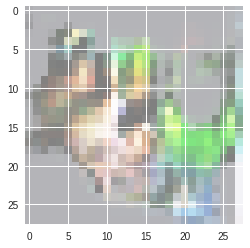

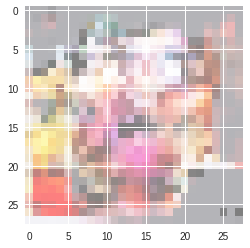

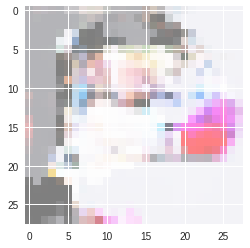

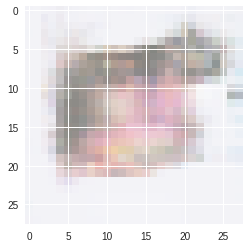

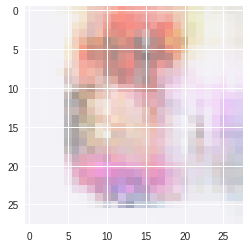

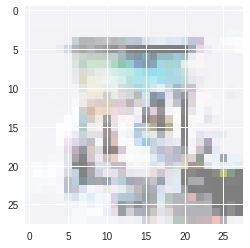

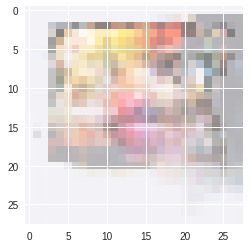

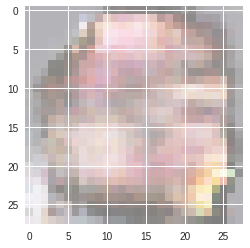

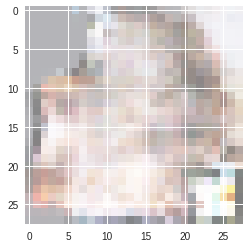

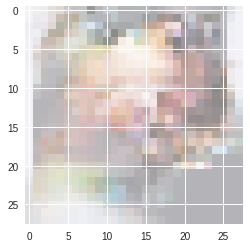

Epoch [4/50], Step [1/390], d_loss: -1.4204, g_loss: 2.3380, D(x): 1.75, D(G(z)): 0.33
Epoch [4/50], Step [2/390], d_loss: -1.8332, g_loss: -0.4989, D(x): -0.21, D(G(z)): -2.04
Epoch [4/50], Step [3/390], d_loss: -1.7690, g_loss: 2.6941, D(x): 2.57, D(G(z)): 0.80
Epoch [4/50], Step [4/390], d_loss: -3.0245, g_loss: -0.4819, D(x): 0.67, D(G(z)): -2.36
Epoch [4/50], Step [5/390], d_loss: -1.9148, g_loss: 1.4410, D(x): 2.53, D(G(z)): 0.61
Epoch [4/50], Step [6/390], d_loss: -1.8793, g_loss: 1.5723, D(x): 0.89, D(G(z)): -0.99
Epoch [4/50], Step [7/390], d_loss: -2.5058, g_loss: 2.4902, D(x): 1.30, D(G(z)): -1.21
Epoch [4/50], Step [8/390], d_loss: -1.7855, g_loss: -1.2924, D(x): -0.27, D(G(z)): -2.06
Epoch [4/50], Step [9/390], d_loss: -0.9940, g_loss: 0.7429, D(x): 2.67, D(G(z)): 1.68
Epoch [4/50], Step [10/390], d_loss: -1.3864, g_loss: 1.3921, D(x): 0.92, D(G(z)): -0.47
Epoch [4/50], Step [11/390], d_loss: -2.2020, g_loss: 2.4079, D(x): 1.36, D(G(z)): -0.84
Epoch [4/50], Step [12/390], 

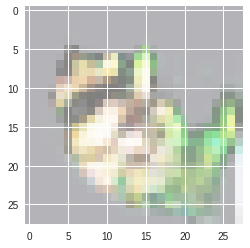

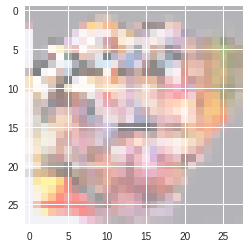

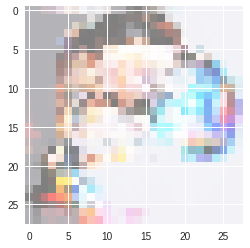

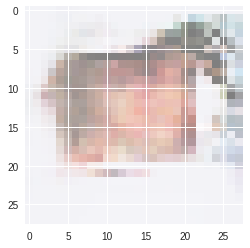

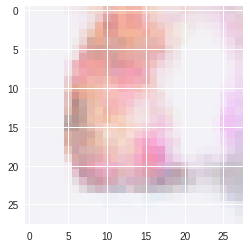

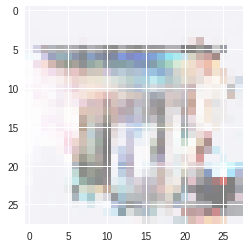

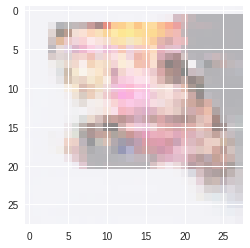

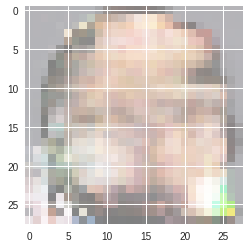

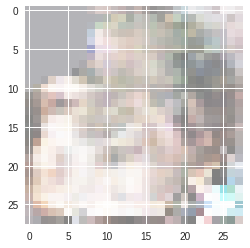

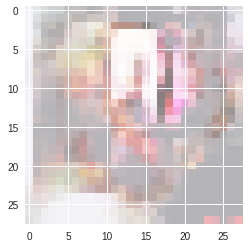

Epoch [5/50], Step [1/390], d_loss: -1.2167, g_loss: -0.1846, D(x): -0.95, D(G(z)): -2.17
Epoch [5/50], Step [2/390], d_loss: -1.2644, g_loss: 2.5824, D(x): 2.07, D(G(z)): 0.80
Epoch [5/50], Step [3/390], d_loss: -0.9502, g_loss: -0.1094, D(x): -1.18, D(G(z)): -2.13
Epoch [5/50], Step [4/390], d_loss: -2.1327, g_loss: 2.6561, D(x): 2.62, D(G(z)): 0.49
Epoch [5/50], Step [5/390], d_loss: -2.0894, g_loss: 0.5160, D(x): -0.16, D(G(z)): -2.25
Epoch [5/50], Step [6/390], d_loss: -1.6575, g_loss: 2.1225, D(x): 1.68, D(G(z)): 0.02
Epoch [5/50], Step [7/390], d_loss: -1.8518, g_loss: 1.0777, D(x): 0.17, D(G(z)): -1.68
Epoch [5/50], Step [8/390], d_loss: -1.5271, g_loss: 2.0553, D(x): 1.08, D(G(z)): -0.45
Epoch [5/50], Step [9/390], d_loss: -1.8726, g_loss: 0.0019, D(x): 0.39, D(G(z)): -1.48
Epoch [5/50], Step [10/390], d_loss: -1.1289, g_loss: 2.7587, D(x): 1.92, D(G(z)): 0.79
Epoch [5/50], Step [11/390], d_loss: -1.3392, g_loss: -1.2274, D(x): -1.12, D(G(z)): -2.46
Epoch [5/50], Step [12/390]

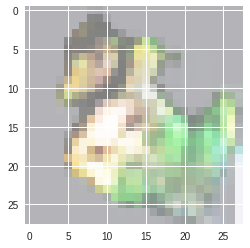

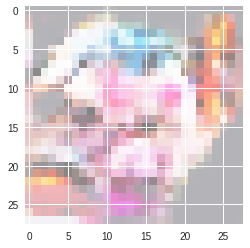

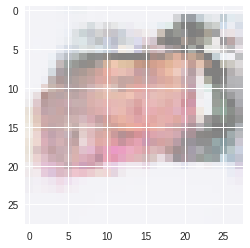

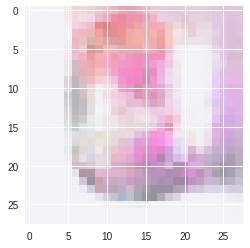

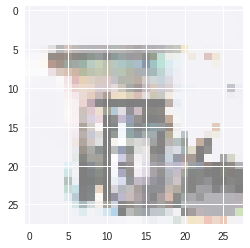

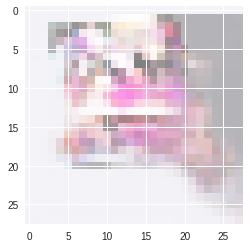

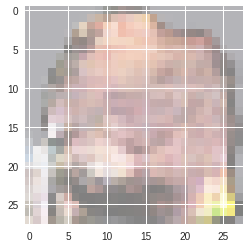

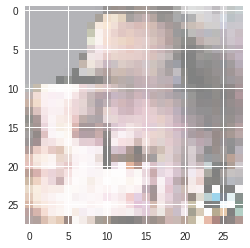

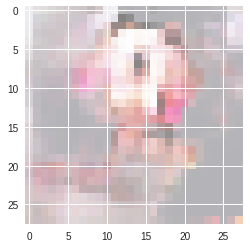

Epoch [6/50], Step [1/390], d_loss: -1.1081, g_loss: -0.4550, D(x): -1.07, D(G(z)): -2.17
Epoch [6/50], Step [2/390], d_loss: -1.0736, g_loss: 2.1293, D(x): 2.10, D(G(z)): 1.03
Epoch [6/50], Step [3/390], d_loss: -1.0251, g_loss: -0.5379, D(x): -0.55, D(G(z)): -1.58
Epoch [6/50], Step [4/390], d_loss: -1.9400, g_loss: 2.3906, D(x): 2.89, D(G(z)): 0.95
Epoch [6/50], Step [5/390], d_loss: -1.9827, g_loss: 0.0603, D(x): -0.11, D(G(z)): -2.09
Epoch [6/50], Step [6/390], d_loss: -1.6218, g_loss: 2.1831, D(x): 2.04, D(G(z)): 0.41
Epoch [6/50], Step [7/390], d_loss: -1.6021, g_loss: 0.6004, D(x): -0.21, D(G(z)): -1.82
Epoch [6/50], Step [8/390], d_loss: -1.2562, g_loss: 2.0553, D(x): 1.32, D(G(z)): 0.06
Epoch [6/50], Step [9/390], d_loss: -1.4548, g_loss: 0.2494, D(x): 0.06, D(G(z)): -1.39
Epoch [6/50], Step [10/390], d_loss: -1.3015, g_loss: 2.8644, D(x): 1.48, D(G(z)): 0.18
Epoch [6/50], Step [11/390], d_loss: -1.1794, g_loss: -1.0479, D(x): -1.41, D(G(z)): -2.59
Epoch [6/50], Step [12/390]

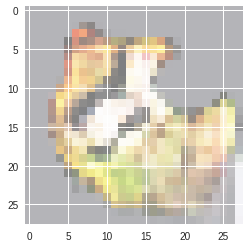

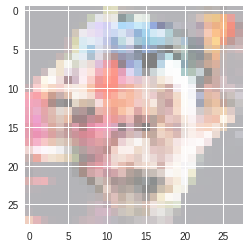

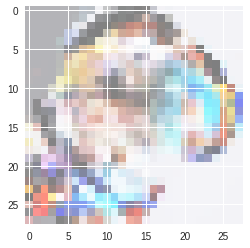

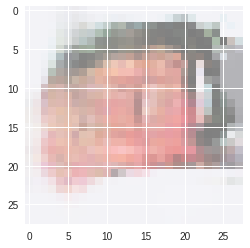

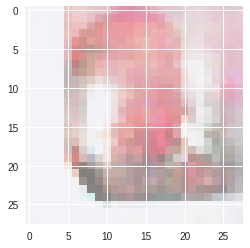

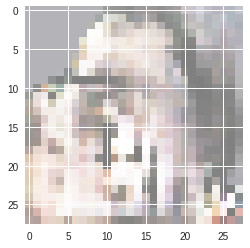

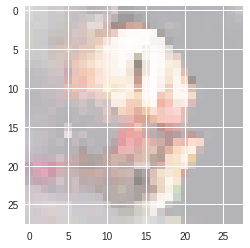

Epoch [7/50], Step [1/390], d_loss: -1.3757, g_loss: 0.4499, D(x): 0.51, D(G(z)): -0.86
Epoch [7/50], Step [2/390], d_loss: -1.2339, g_loss: 2.1793, D(x): 1.61, D(G(z)): 0.37
Epoch [7/50], Step [3/390], d_loss: -0.9484, g_loss: -0.8161, D(x): -0.76, D(G(z)): -1.71
Epoch [7/50], Step [4/390], d_loss: -1.2553, g_loss: 1.8765, D(x): 2.87, D(G(z)): 1.62
Epoch [7/50], Step [5/390], d_loss: -1.7270, g_loss: 0.5323, D(x): 0.09, D(G(z)): -1.63
Epoch [7/50], Step [6/390], d_loss: -1.6708, g_loss: 2.5875, D(x): 1.71, D(G(z)): 0.04
Epoch [7/50], Step [7/390], d_loss: -1.3685, g_loss: -0.7768, D(x): -0.78, D(G(z)): -2.15
Epoch [7/50], Step [8/390], d_loss: -0.6560, g_loss: 0.8546, D(x): 2.09, D(G(z)): 1.43
Epoch [7/50], Step [9/390], d_loss: -0.9805, g_loss: 1.8328, D(x): 0.71, D(G(z)): -0.28
Epoch [7/50], Step [10/390], d_loss: -1.2420, g_loss: 1.0027, D(x): -0.09, D(G(z)): -1.33
Epoch [7/50], Step [11/390], d_loss: -1.0717, g_loss: 2.1554, D(x): 1.02, D(G(z)): -0.05
Epoch [7/50], Step [12/390], 

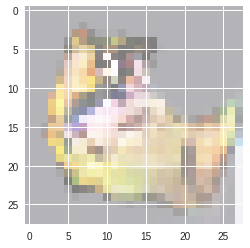

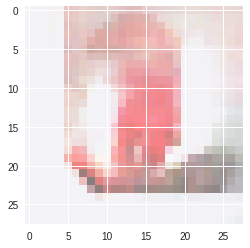

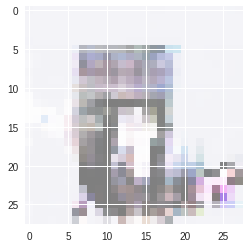

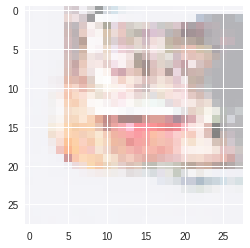

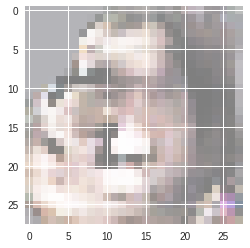

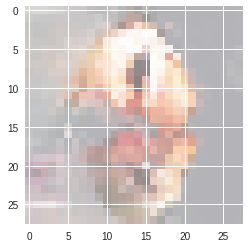

Epoch [8/50], Step [1/390], d_loss: -0.8504, g_loss: -0.0292, D(x): -0.93, D(G(z)): -1.78
Epoch [8/50], Step [2/390], d_loss: -1.1695, g_loss: 2.4235, D(x): 1.73, D(G(z)): 0.56
Epoch [8/50], Step [3/390], d_loss: -0.7952, g_loss: -1.1263, D(x): -1.30, D(G(z)): -2.09
Epoch [8/50], Step [4/390], d_loss: -1.3281, g_loss: 2.0677, D(x): 2.98, D(G(z)): 1.66
Epoch [8/50], Step [5/390], d_loss: -1.8563, g_loss: 0.4082, D(x): -0.01, D(G(z)): -1.87
Epoch [8/50], Step [6/390], d_loss: -1.5009, g_loss: 2.2232, D(x): 1.67, D(G(z)): 0.17
Epoch [8/50], Step [7/390], d_loss: -1.3589, g_loss: -0.2568, D(x): -0.48, D(G(z)): -1.84
Epoch [8/50], Step [8/390], d_loss: -0.8929, g_loss: 1.7071, D(x): 1.69, D(G(z)): 0.80
Epoch [8/50], Step [9/390], d_loss: -1.2498, g_loss: 0.6623, D(x): 0.00, D(G(z)): -1.25
Epoch [8/50], Step [10/390], d_loss: -0.9985, g_loss: 1.7593, D(x): 0.96, D(G(z)): -0.04
Epoch [8/50], Step [11/390], d_loss: -1.5245, g_loss: 0.5046, D(x): 0.40, D(G(z)): -1.12
Epoch [8/50], Step [12/390]

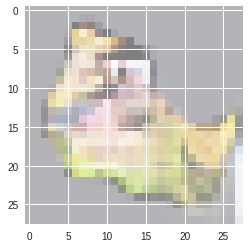

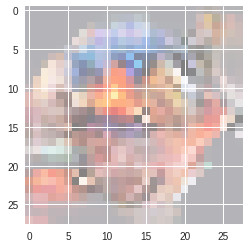

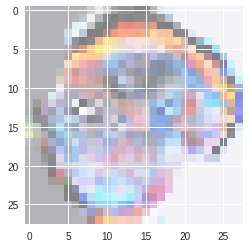

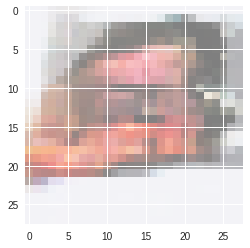

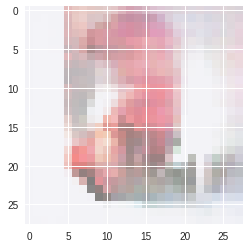

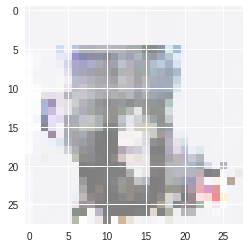

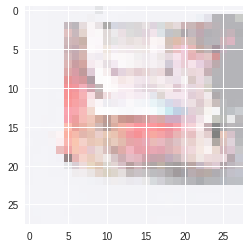

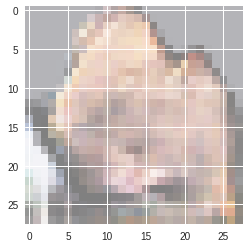

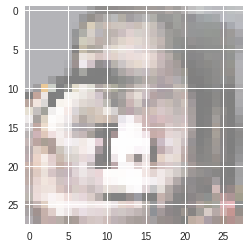

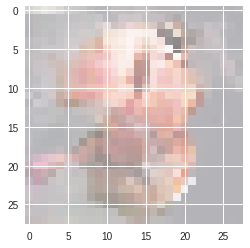

Epoch [9/50], Step [1/390], d_loss: -0.9677, g_loss: 2.0217, D(x): 1.64, D(G(z)): 0.68
Epoch [9/50], Step [2/390], d_loss: -1.0969, g_loss: -1.2211, D(x): -0.59, D(G(z)): -1.69
Epoch [9/50], Step [3/390], d_loss: -0.9416, g_loss: 1.7195, D(x): 2.63, D(G(z)): 1.69
Epoch [9/50], Step [4/390], d_loss: -2.1195, g_loss: -0.2642, D(x): 0.81, D(G(z)): -1.31
Epoch [9/50], Step [5/390], d_loss: -1.3968, g_loss: 1.4022, D(x): 2.20, D(G(z)): 0.80
Epoch [9/50], Step [6/390], d_loss: -1.3271, g_loss: 0.9269, D(x): 0.35, D(G(z)): -0.97
Epoch [9/50], Step [7/390], d_loss: -1.2982, g_loss: 1.5147, D(x): 0.81, D(G(z)): -0.48
Epoch [9/50], Step [8/390], d_loss: -0.6220, g_loss: -0.3171, D(x): -0.25, D(G(z)): -0.87
Epoch [9/50], Step [9/390], d_loss: -0.8216, g_loss: 1.4916, D(x): 1.61, D(G(z)): 0.79
Epoch [9/50], Step [10/390], d_loss: -0.8084, g_loss: 0.5823, D(x): -0.16, D(G(z)): -0.97
Epoch [9/50], Step [11/390], d_loss: -0.9645, g_loss: 2.1708, D(x): 1.28, D(G(z)): 0.32
Epoch [9/50], Step [12/390], 

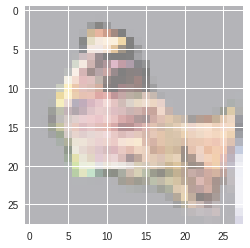

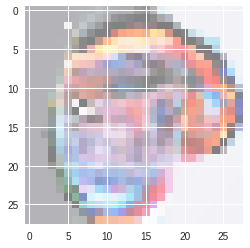

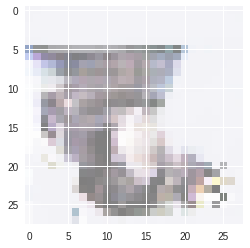

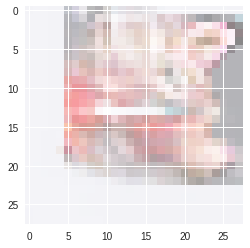

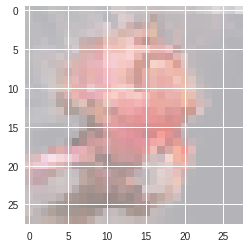

Epoch [10/50], Step [1/390], d_loss: -0.7227, g_loss: 1.8661, D(x): 2.26, D(G(z)): 1.54
Epoch [10/50], Step [2/390], d_loss: -0.9632, g_loss: -0.3600, D(x): -0.40, D(G(z)): -1.36
Epoch [10/50], Step [3/390], d_loss: -1.0050, g_loss: 1.4948, D(x): 2.06, D(G(z)): 1.05
Epoch [10/50], Step [4/390], d_loss: -2.0841, g_loss: 0.7411, D(x): 1.18, D(G(z)): -0.91
Epoch [10/50], Step [5/390], d_loss: -1.7569, g_loss: 2.1794, D(x): 1.65, D(G(z)): -0.11
Epoch [10/50], Step [6/390], d_loss: -1.3329, g_loss: -0.1900, D(x): -0.57, D(G(z)): -1.90
Epoch [10/50], Step [7/390], d_loss: -0.9307, g_loss: 1.5543, D(x): 1.86, D(G(z)): 0.93
Epoch [10/50], Step [8/390], d_loss: -0.7738, g_loss: 0.4152, D(x): -0.49, D(G(z)): -1.26
Epoch [10/50], Step [9/390], d_loss: -0.8635, g_loss: 2.1620, D(x): 1.21, D(G(z)): 0.35
Epoch [10/50], Step [10/390], d_loss: -0.6363, g_loss: 0.2328, D(x): -1.04, D(G(z)): -1.67
Epoch [10/50], Step [11/390], d_loss: -0.8957, g_loss: 2.4275, D(x): 1.58, D(G(z)): 0.69
Epoch [10/50], Ste

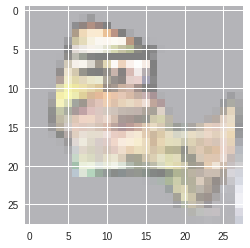

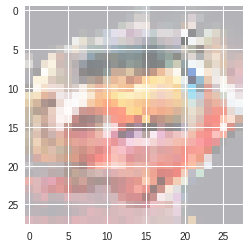

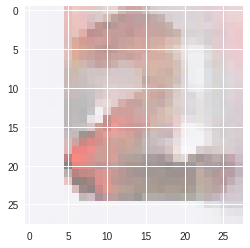

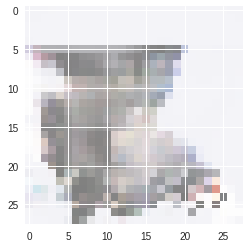

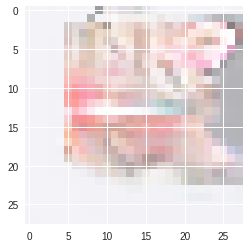

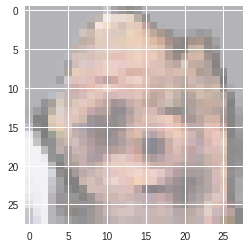

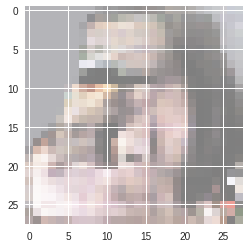

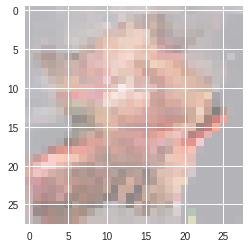

Epoch [11/50], Step [1/390], d_loss: -0.8172, g_loss: 2.2467, D(x): 1.67, D(G(z)): 0.85
Epoch [11/50], Step [2/390], d_loss: -0.9823, g_loss: -1.3266, D(x): -0.74, D(G(z)): -1.72
Epoch [11/50], Step [3/390], d_loss: -0.7275, g_loss: 1.5695, D(x): 2.43, D(G(z)): 1.70
Epoch [11/50], Step [4/390], d_loss: -1.5259, g_loss: 0.1784, D(x): 0.62, D(G(z)): -0.91
Epoch [11/50], Step [5/390], d_loss: -1.3924, g_loss: 1.3294, D(x): 1.87, D(G(z)): 0.48
Epoch [11/50], Step [6/390], d_loss: -1.4632, g_loss: 0.4064, D(x): 0.27, D(G(z)): -1.19
Epoch [11/50], Step [7/390], d_loss: -1.1258, g_loss: 2.2080, D(x): 1.41, D(G(z)): 0.28
Epoch [11/50], Step [8/390], d_loss: -0.3925, g_loss: -0.1613, D(x): -1.39, D(G(z)): -1.78
Epoch [11/50], Step [9/390], d_loss: -0.5630, g_loss: 0.2501, D(x): 1.32, D(G(z)): 0.76
Epoch [11/50], Step [10/390], d_loss: -0.1978, g_loss: 0.0239, D(x): 0.58, D(G(z)): 0.38
Epoch [11/50], Step [11/390], d_loss: -0.7904, g_loss: 1.1462, D(x): 1.35, D(G(z)): 0.56
Epoch [11/50], Step [1

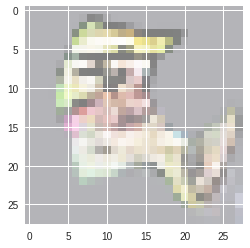

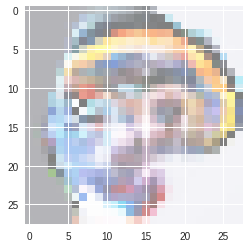

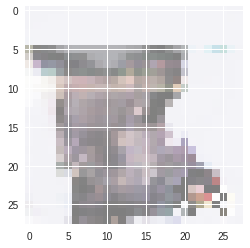

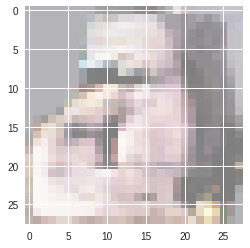

Epoch [12/50], Step [1/390], d_loss: -0.7856, g_loss: 1.5924, D(x): 1.47, D(G(z)): 0.68
Epoch [12/50], Step [2/390], d_loss: -1.0518, g_loss: -0.3018, D(x): -0.10, D(G(z)): -1.15
Epoch [12/50], Step [3/390], d_loss: -1.1252, g_loss: 2.2485, D(x): 2.00, D(G(z)): 0.87
Epoch [12/50], Step [4/390], d_loss: -1.7549, g_loss: -1.2319, D(x): -0.09, D(G(z)): -1.84
Epoch [12/50], Step [5/390], d_loss: -1.1099, g_loss: 0.5468, D(x): 2.56, D(G(z)): 1.45
Epoch [12/50], Step [6/390], d_loss: -1.0570, g_loss: 0.6846, D(x): 0.98, D(G(z)): -0.08
Epoch [12/50], Step [7/390], d_loss: -1.1213, g_loss: 1.0668, D(x): 0.75, D(G(z)): -0.38
Epoch [12/50], Step [8/390], d_loss: -0.6324, g_loss: 0.2226, D(x): 0.33, D(G(z)): -0.30
Epoch [12/50], Step [9/390], d_loss: -0.6482, g_loss: 1.5970, D(x): 1.16, D(G(z)): 0.51
Epoch [12/50], Step [10/390], d_loss: -0.4977, g_loss: 0.4107, D(x): -0.74, D(G(z)): -1.24
Epoch [12/50], Step [11/390], d_loss: -0.8080, g_loss: 1.7775, D(x): 1.30, D(G(z)): 0.49
Epoch [12/50], Step

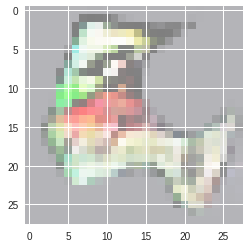

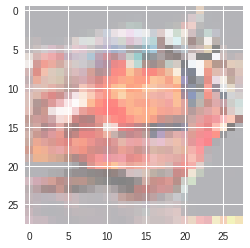

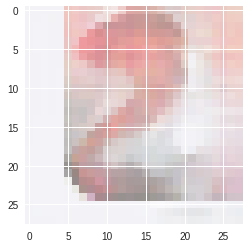

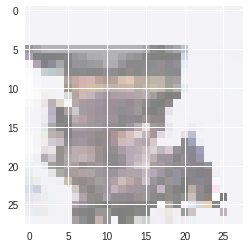

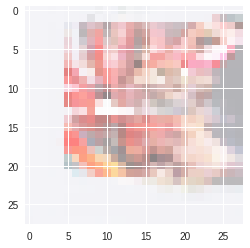

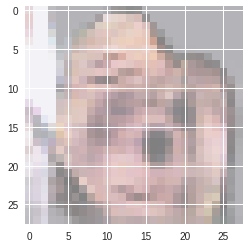

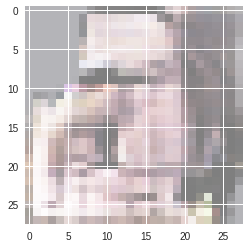

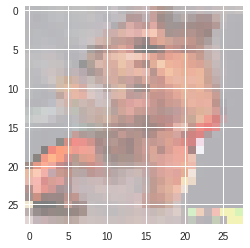

Epoch [13/50], Step [1/390], d_loss: -0.9309, g_loss: 1.6935, D(x): 1.28, D(G(z)): 0.35
Epoch [13/50], Step [2/390], d_loss: -1.1702, g_loss: -0.7583, D(x): -0.09, D(G(z)): -1.26
Epoch [13/50], Step [3/390], d_loss: -0.8166, g_loss: 1.9911, D(x): 2.21, D(G(z)): 1.39
Epoch [13/50], Step [4/390], d_loss: -2.2647, g_loss: -0.8152, D(x): 0.70, D(G(z)): -1.56
Epoch [13/50], Step [5/390], d_loss: -1.1652, g_loss: 1.2893, D(x): 2.61, D(G(z)): 1.44
Epoch [13/50], Step [6/390], d_loss: -1.3487, g_loss: 0.5203, D(x): 0.28, D(G(z)): -1.07
Epoch [13/50], Step [7/390], d_loss: -1.2810, g_loss: 1.5635, D(x): 1.13, D(G(z)): -0.15
Epoch [13/50], Step [8/390], d_loss: -0.8632, g_loss: -0.1558, D(x): -0.18, D(G(z)): -1.04
Epoch [13/50], Step [9/390], d_loss: -0.9140, g_loss: 2.2399, D(x): 1.66, D(G(z)): 0.74
Epoch [13/50], Step [10/390], d_loss: -0.5543, g_loss: 0.1274, D(x): -1.33, D(G(z)): -1.88
Epoch [13/50], Step [11/390], d_loss: -0.7090, g_loss: 2.3469, D(x): 1.51, D(G(z)): 0.80
Epoch [13/50], Ste

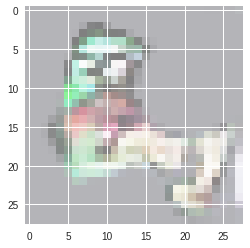

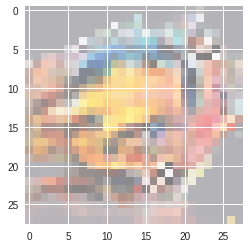

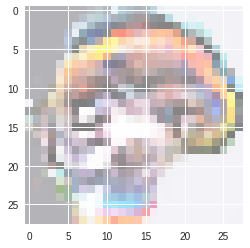

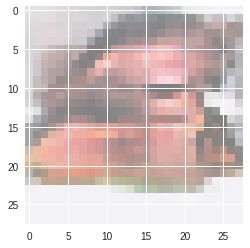

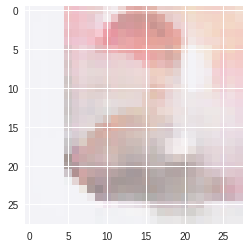

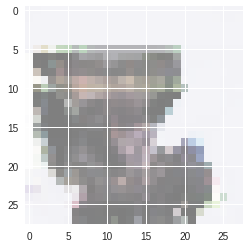

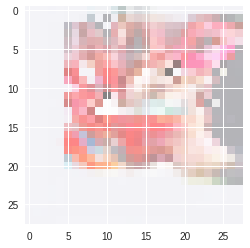

Epoch [14/50], Step [1/390], d_loss: -0.9077, g_loss: -0.7714, D(x): -0.09, D(G(z)): -1.00
Epoch [14/50], Step [2/390], d_loss: -0.7855, g_loss: 2.8872, D(x): 2.14, D(G(z)): 1.35
Epoch [14/50], Step [3/390], d_loss: -0.2871, g_loss: 0.3555, D(x): -2.38, D(G(z)): -2.66
Epoch [14/50], Step [4/390], d_loss: -1.4323, g_loss: 1.6219, D(x): 1.68, D(G(z)): 0.24
Epoch [14/50], Step [5/390], d_loss: -1.6534, g_loss: 0.9683, D(x): 0.44, D(G(z)): -1.21
Epoch [14/50], Step [6/390], d_loss: -1.2549, g_loss: 1.0334, D(x): 0.86, D(G(z)): -0.39
Epoch [14/50], Step [7/390], d_loss: -1.1797, g_loss: 1.1562, D(x): 0.57, D(G(z)): -0.61
Epoch [14/50], Step [8/390], d_loss: -0.8254, g_loss: 0.5144, D(x): 0.21, D(G(z)): -0.62
Epoch [14/50], Step [9/390], d_loss: -0.7188, g_loss: 1.2559, D(x): 1.17, D(G(z)): 0.45
Epoch [14/50], Step [10/390], d_loss: -0.4241, g_loss: 1.4030, D(x): -0.29, D(G(z)): -0.71
Epoch [14/50], Step [11/390], d_loss: -0.7227, g_loss: -0.1719, D(x): 0.09, D(G(z)): -0.63
Epoch [14/50], St

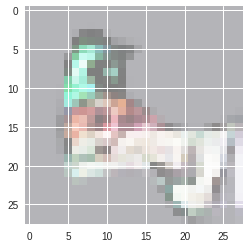

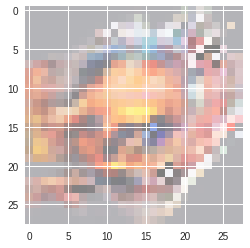

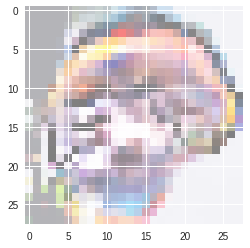

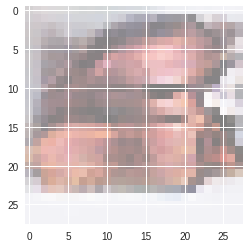

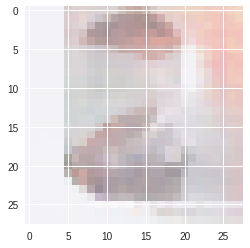

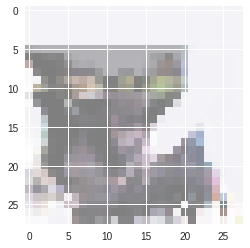

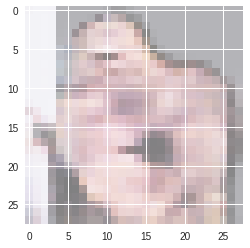

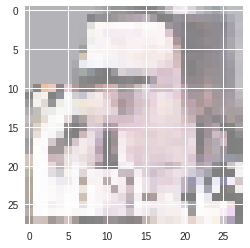

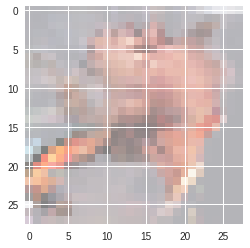

Epoch [15/50], Step [1/390], d_loss: -0.7782, g_loss: 1.0518, D(x): 0.78, D(G(z)): 0.01
Epoch [15/50], Step [2/390], d_loss: -0.7892, g_loss: 0.8168, D(x): 0.47, D(G(z)): -0.32
Epoch [15/50], Step [3/390], d_loss: -1.0126, g_loss: 0.1251, D(x): 0.92, D(G(z)): -0.09
Epoch [15/50], Step [4/390], d_loss: -1.8410, g_loss: 3.2313, D(x): 2.51, D(G(z)): 0.67
Epoch [15/50], Step [5/390], d_loss: -0.9068, g_loss: 0.5029, D(x): -2.24, D(G(z)): -3.15
Epoch [15/50], Step [6/390], d_loss: -1.0279, g_loss: 1.3112, D(x): 0.97, D(G(z)): -0.06
Epoch [15/50], Step [7/390], d_loss: -1.1454, g_loss: 0.7226, D(x): 0.22, D(G(z)): -0.92
Epoch [15/50], Step [8/390], d_loss: -0.8929, g_loss: 0.8679, D(x): 0.64, D(G(z)): -0.25
Epoch [15/50], Step [9/390], d_loss: -0.8044, g_loss: 1.0781, D(x): 0.70, D(G(z)): -0.11
Epoch [15/50], Step [10/390], d_loss: -0.3167, g_loss: 1.1895, D(x): -0.21, D(G(z)): -0.53
Epoch [15/50], Step [11/390], d_loss: -0.8716, g_loss: 0.9405, D(x): 0.38, D(G(z)): -0.49
Epoch [15/50], Step

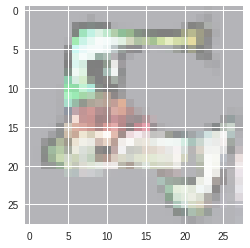

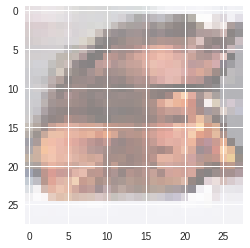

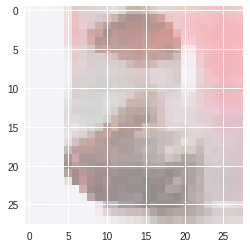

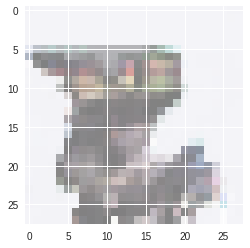

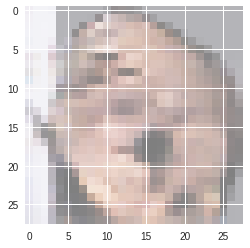

Epoch [16/50], Step [1/390], d_loss: -0.6724, g_loss: 1.9759, D(x): 1.83, D(G(z)): 1.16
Epoch [16/50], Step [2/390], d_loss: -0.9891, g_loss: -1.6124, D(x): -0.71, D(G(z)): -1.70
Epoch [16/50], Step [3/390], d_loss: -0.4594, g_loss: -0.3564, D(x): 2.54, D(G(z)): 2.08
Epoch [16/50], Step [4/390], d_loss: -1.3048, g_loss: 1.8119, D(x): 2.30, D(G(z)): 1.00
Epoch [16/50], Step [5/390], d_loss: -1.8843, g_loss: -0.1689, D(x): 0.22, D(G(z)): -1.67
Epoch [16/50], Step [6/390], d_loss: -1.1300, g_loss: 1.5811, D(x): 1.94, D(G(z)): 0.81
Epoch [16/50], Step [7/390], d_loss: -1.1618, g_loss: -0.0435, D(x): -0.19, D(G(z)): -1.35
Epoch [16/50], Step [8/390], d_loss: -0.5322, g_loss: 0.8893, D(x): 1.27, D(G(z)): 0.73
Epoch [16/50], Step [9/390], d_loss: -0.8088, g_loss: 1.6727, D(x): 0.32, D(G(z)): -0.49
Epoch [16/50], Step [10/390], d_loss: -0.3128, g_loss: 1.1172, D(x): -0.70, D(G(z)): -1.01
Epoch [16/50], Step [11/390], d_loss: -0.8405, g_loss: 0.6322, D(x): 0.46, D(G(z)): -0.38
Epoch [16/50], St

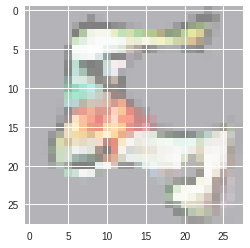

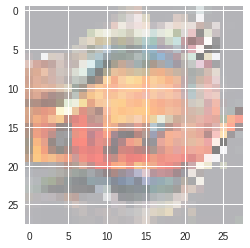

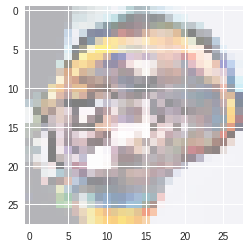

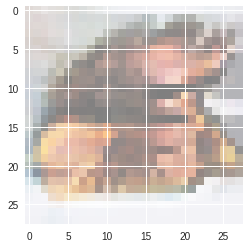

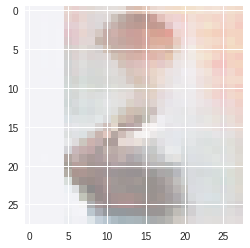

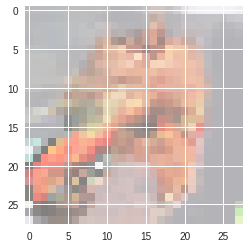

Epoch [17/50], Step [1/390], d_loss: -0.6644, g_loss: 1.8941, D(x): 1.29, D(G(z)): 0.63
Epoch [17/50], Step [2/390], d_loss: -0.6380, g_loss: -0.9375, D(x): -0.78, D(G(z)): -1.42
Epoch [17/50], Step [3/390], d_loss: -0.7188, g_loss: 1.8695, D(x): 2.14, D(G(z)): 1.42
Epoch [17/50], Step [4/390], d_loss: -1.9753, g_loss: -1.3541, D(x): 0.44, D(G(z)): -1.53
Epoch [17/50], Step [5/390], d_loss: -0.8572, g_loss: 0.8570, D(x): 2.70, D(G(z)): 1.84
Epoch [17/50], Step [6/390], d_loss: -1.1896, g_loss: 0.8809, D(x): 0.44, D(G(z)): -0.75
Epoch [17/50], Step [7/390], d_loss: -1.0144, g_loss: 1.2694, D(x): 0.68, D(G(z)): -0.33
Epoch [17/50], Step [8/390], d_loss: -0.7780, g_loss: -0.5163, D(x): -0.04, D(G(z)): -0.82
Epoch [17/50], Step [9/390], d_loss: -0.5900, g_loss: 0.8141, D(x): 1.71, D(G(z)): 1.12
Epoch [17/50], Step [10/390], d_loss: -0.0663, g_loss: 0.9004, D(x): -0.13, D(G(z)): -0.20
Epoch [17/50], Step [11/390], d_loss: -0.6267, g_loss: -0.2869, D(x): 0.33, D(G(z)): -0.29
Epoch [17/50], S

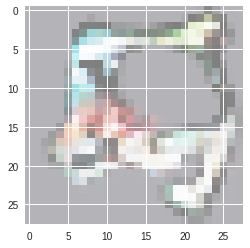

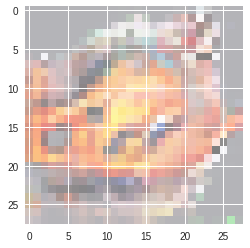

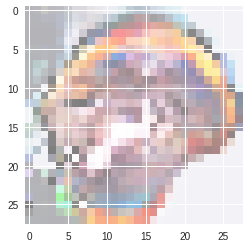

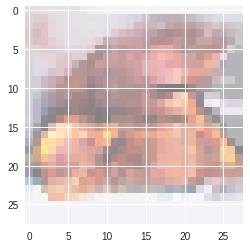

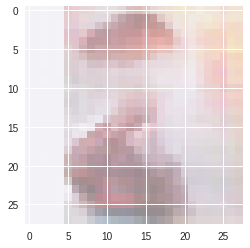

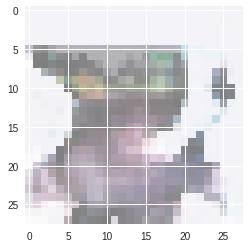

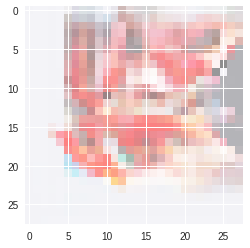

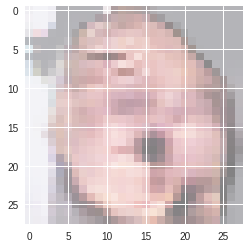

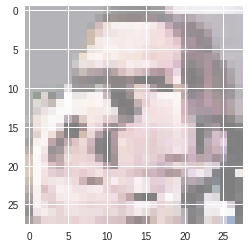

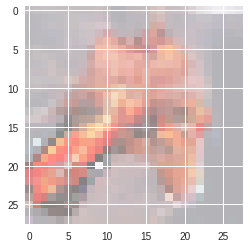

Epoch [18/50], Step [1/390], d_loss: -0.7428, g_loss: 2.2920, D(x): 1.46, D(G(z)): 0.72
Epoch [18/50], Step [2/390], d_loss: -0.7480, g_loss: -1.4506, D(x): -1.23, D(G(z)): -1.98
Epoch [18/50], Step [3/390], d_loss: -0.6526, g_loss: 1.3330, D(x): 2.57, D(G(z)): 1.92
Epoch [18/50], Step [4/390], d_loss: -1.7237, g_loss: -0.1151, D(x): 0.86, D(G(z)): -0.86
Epoch [18/50], Step [5/390], d_loss: -1.3533, g_loss: 1.9414, D(x): 2.00, D(G(z)): 0.64
Epoch [18/50], Step [6/390], d_loss: -1.0813, g_loss: 0.0281, D(x): -0.60, D(G(z)): -1.69
Epoch [18/50], Step [7/390], d_loss: -0.8834, g_loss: 1.5572, D(x): 1.26, D(G(z)): 0.37
Epoch [18/50], Step [8/390], d_loss: -0.7068, g_loss: -0.1334, D(x): -0.58, D(G(z)): -1.29
Epoch [18/50], Step [9/390], d_loss: -0.5054, g_loss: 0.6751, D(x): 1.17, D(G(z)): 0.67
Epoch [18/50], Step [10/390], d_loss: -0.1602, g_loss: 0.7290, D(x): 0.06, D(G(z)): -0.10
Epoch [18/50], Step [11/390], d_loss: -0.7012, g_loss: 0.2848, D(x): 0.45, D(G(z)): -0.25
Epoch [18/50], Ste

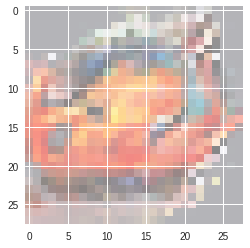

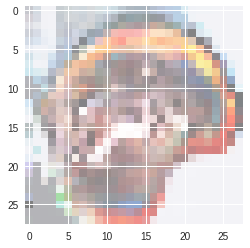

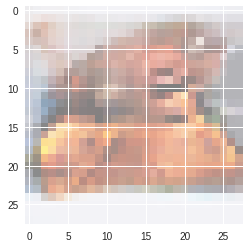

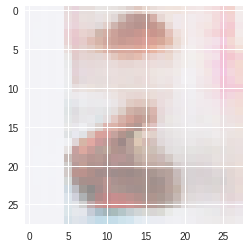

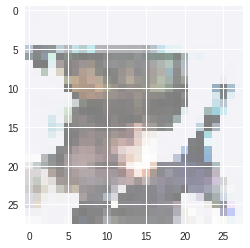

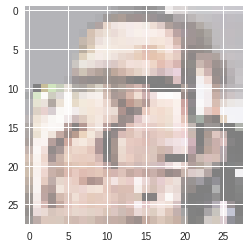

Epoch [19/50], Step [1/390], d_loss: -0.8037, g_loss: 1.9909, D(x): 1.32, D(G(z)): 0.51
Epoch [19/50], Step [2/390], d_loss: -0.8711, g_loss: -1.4349, D(x): -0.58, D(G(z)): -1.45
Epoch [19/50], Step [3/390], d_loss: -0.7356, g_loss: 1.8711, D(x): 2.62, D(G(z)): 1.89
Epoch [19/50], Step [4/390], d_loss: -1.5275, g_loss: -1.1196, D(x): 0.11, D(G(z)): -1.42
Epoch [19/50], Step [5/390], d_loss: -1.0400, g_loss: 0.9570, D(x): 2.50, D(G(z)): 1.46
Epoch [19/50], Step [6/390], d_loss: -1.0987, g_loss: 0.9249, D(x): 0.56, D(G(z)): -0.54
Epoch [19/50], Step [7/390], d_loss: -1.0390, g_loss: 0.8165, D(x): 0.47, D(G(z)): -0.57
Epoch [19/50], Step [8/390], d_loss: -0.8389, g_loss: 0.5677, D(x): 0.40, D(G(z)): -0.44
Epoch [19/50], Step [9/390], d_loss: -0.4368, g_loss: 0.6065, D(x): 0.86, D(G(z)): 0.43
Epoch [19/50], Step [10/390], d_loss: 0.1410, g_loss: 0.8264, D(x): 0.02, D(G(z)): 0.17
Epoch [19/50], Step [11/390], d_loss: -0.7428, g_loss: 0.7925, D(x): 0.37, D(G(z)): -0.37
Epoch [19/50], Step [1

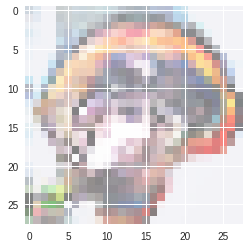

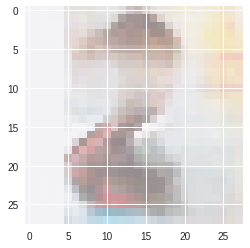

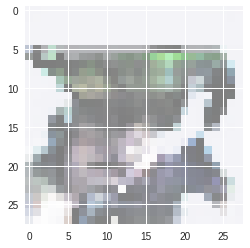

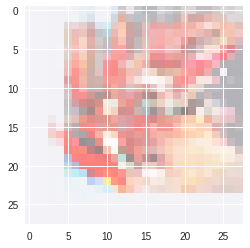

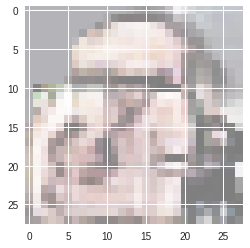

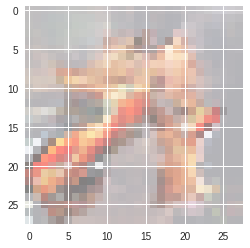

Epoch [20/50], Step [1/390], d_loss: -0.5611, g_loss: 1.1379, D(x): 1.42, D(G(z)): 0.86
Epoch [20/50], Step [2/390], d_loss: -0.8523, g_loss: 0.5191, D(x): 0.11, D(G(z)): -0.74
Epoch [20/50], Step [3/390], d_loss: -0.8556, g_loss: 0.6409, D(x): 1.25, D(G(z)): 0.39
Epoch [20/50], Step [4/390], d_loss: -1.8026, g_loss: 3.0172, D(x): 2.04, D(G(z)): 0.24
Epoch [20/50], Step [5/390], d_loss: -1.0862, g_loss: -0.3668, D(x): -1.87, D(G(z)): -2.95
Epoch [20/50], Step [6/390], d_loss: -0.9642, g_loss: 1.2227, D(x): 1.65, D(G(z)): 0.68
Epoch [20/50], Step [7/390], d_loss: -0.9346, g_loss: 0.5861, D(x): 0.15, D(G(z)): -0.78
Epoch [20/50], Step [8/390], d_loss: -0.8517, g_loss: 0.7328, D(x): 0.56, D(G(z)): -0.29
Epoch [20/50], Step [9/390], d_loss: -0.6544, g_loss: 0.7598, D(x): 0.65, D(G(z)): -0.01
Epoch [20/50], Step [10/390], d_loss: -0.3443, g_loss: 1.0823, D(x): 0.03, D(G(z)): -0.32
Epoch [20/50], Step [11/390], d_loss: -0.7341, g_loss: 0.1663, D(x): 0.37, D(G(z)): -0.37
Epoch [20/50], Step [

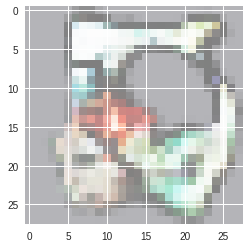

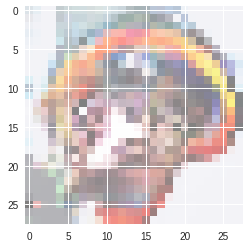

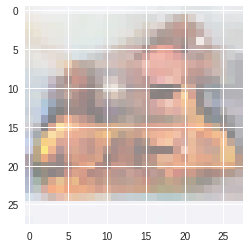

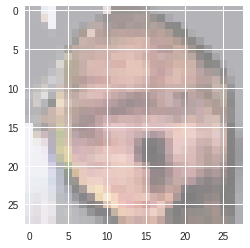

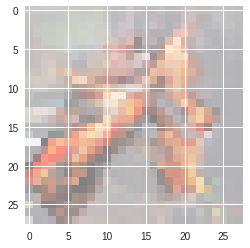

Epoch [21/50], Step [1/390], d_loss: -0.7416, g_loss: 1.8041, D(x): 1.15, D(G(z)): 0.41
Epoch [21/50], Step [2/390], d_loss: -1.0102, g_loss: -1.7172, D(x): -0.32, D(G(z)): -1.33
Epoch [21/50], Step [3/390], d_loss: -0.5621, g_loss: 0.2138, D(x): 2.70, D(G(z)): 2.14
Epoch [21/50], Step [4/390], d_loss: -1.3962, g_loss: 1.3755, D(x): 1.76, D(G(z)): 0.37
Epoch [21/50], Step [5/390], d_loss: -1.4837, g_loss: 1.3603, D(x): 0.77, D(G(z)): -0.71
Epoch [21/50], Step [6/390], d_loss: -1.4765, g_loss: -0.4838, D(x): 0.29, D(G(z)): -1.19
Epoch [21/50], Step [7/390], d_loss: -0.8394, g_loss: 2.6277, D(x): 1.87, D(G(z)): 1.04
Epoch [21/50], Step [8/390], d_loss: -0.4675, g_loss: -0.3924, D(x): -1.88, D(G(z)): -2.35
Epoch [21/50], Step [9/390], d_loss: -0.6640, g_loss: 1.1273, D(x): 1.46, D(G(z)): 0.80
Epoch [21/50], Step [10/390], d_loss: -0.2562, g_loss: 0.8253, D(x): -0.32, D(G(z)): -0.58
Epoch [21/50], Step [11/390], d_loss: -0.4965, g_loss: -0.1796, D(x): 0.27, D(G(z)): -0.23
Epoch [21/50], St

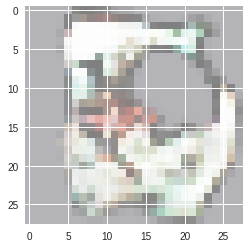

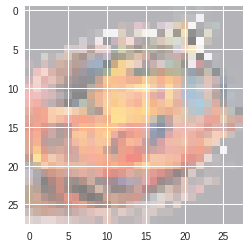

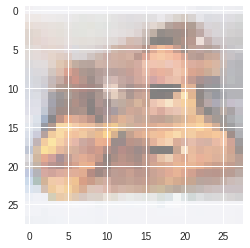

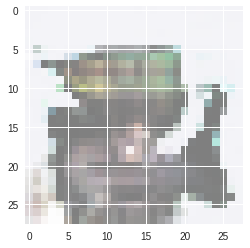

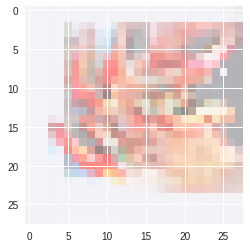

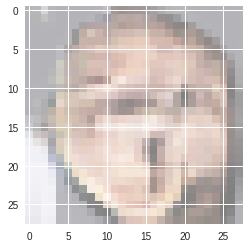

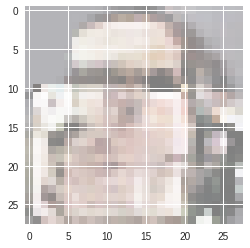

Epoch [22/50], Step [1/390], d_loss: -0.7413, g_loss: -1.1799, D(x): -0.60, D(G(z)): -1.34
Epoch [22/50], Step [2/390], d_loss: -0.5838, g_loss: 2.0989, D(x): 2.23, D(G(z)): 1.65
Epoch [22/50], Step [3/390], d_loss: -0.4356, g_loss: -1.1657, D(x): -1.31, D(G(z)): -1.74
Epoch [22/50], Step [4/390], d_loss: -1.0818, g_loss: 1.9677, D(x): 2.65, D(G(z)): 1.57
Epoch [22/50], Step [5/390], d_loss: -1.3697, g_loss: -0.2057, D(x): -0.20, D(G(z)): -1.57
Epoch [22/50], Step [6/390], d_loss: -1.2138, g_loss: 2.0133, D(x): 1.68, D(G(z)): 0.47
Epoch [22/50], Step [7/390], d_loss: -1.1322, g_loss: -0.2262, D(x): -0.47, D(G(z)): -1.61
Epoch [22/50], Step [8/390], d_loss: -0.8802, g_loss: 1.1867, D(x): 1.49, D(G(z)): 0.61
Epoch [22/50], Step [9/390], d_loss: -0.9251, g_loss: 1.0118, D(x): 0.22, D(G(z)): -0.70
Epoch [22/50], Step [10/390], d_loss: -0.4012, g_loss: 1.3057, D(x): 0.14, D(G(z)): -0.26
Epoch [22/50], Step [11/390], d_loss: -0.6896, g_loss: -0.3342, D(x): 0.00, D(G(z)): -0.69
Epoch [22/50],

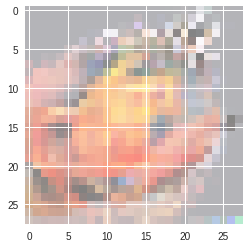

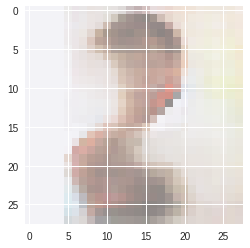

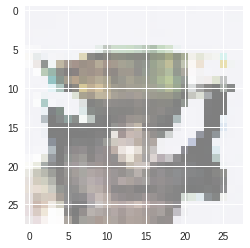

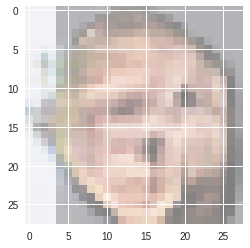

Epoch [23/50], Step [1/390], d_loss: -0.6881, g_loss: -0.8687, D(x): -0.80, D(G(z)): -1.49
Epoch [23/50], Step [2/390], d_loss: -0.7355, g_loss: 2.4431, D(x): 2.06, D(G(z)): 1.33
Epoch [23/50], Step [3/390], d_loss: -0.3705, g_loss: -0.6022, D(x): -1.83, D(G(z)): -2.20
Epoch [23/50], Step [4/390], d_loss: -1.1852, g_loss: 1.6085, D(x): 2.33, D(G(z)): 1.15
Epoch [23/50], Step [5/390], d_loss: -1.4825, g_loss: -0.5000, D(x): 0.04, D(G(z)): -1.44
Epoch [23/50], Step [6/390], d_loss: -1.1085, g_loss: 1.7701, D(x): 1.90, D(G(z)): 0.79
Epoch [23/50], Step [7/390], d_loss: -1.2096, g_loss: -0.4564, D(x): -0.35, D(G(z)): -1.56
Epoch [23/50], Step [8/390], d_loss: -0.6890, g_loss: 0.9035, D(x): 1.64, D(G(z)): 0.95
Epoch [23/50], Step [9/390], d_loss: -0.8571, g_loss: 1.4670, D(x): 0.34, D(G(z)): -0.51
Epoch [23/50], Step [10/390], d_loss: -0.3744, g_loss: 1.3914, D(x): -0.46, D(G(z)): -0.83
Epoch [23/50], Step [11/390], d_loss: -0.6947, g_loss: -1.0817, D(x): -0.05, D(G(z)): -0.74
Epoch [23/50]

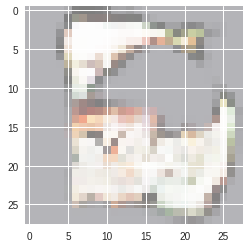

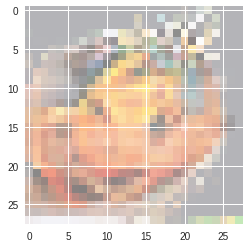

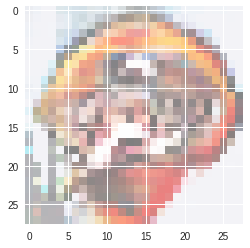

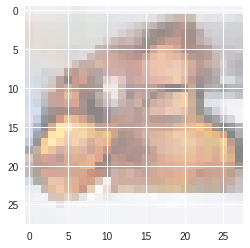

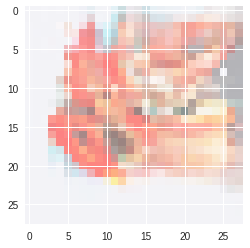

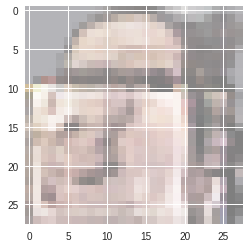

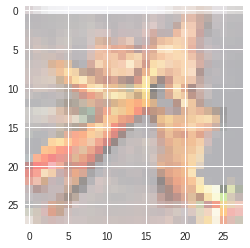

Epoch [24/50], Step [1/390], d_loss: -0.7916, g_loss: 0.2934, D(x): 0.19, D(G(z)): -0.60
Epoch [24/50], Step [2/390], d_loss: -0.8790, g_loss: 1.8742, D(x): 1.28, D(G(z)): 0.40
Epoch [24/50], Step [3/390], d_loss: -0.9952, g_loss: -1.7879, D(x): -0.44, D(G(z)): -1.43
Epoch [24/50], Step [4/390], d_loss: -0.8139, g_loss: 0.4726, D(x): 3.05, D(G(z)): 2.24
Epoch [24/50], Step [5/390], d_loss: -1.2883, g_loss: 1.5758, D(x): 1.07, D(G(z)): -0.22
Epoch [24/50], Step [6/390], d_loss: -1.3665, g_loss: -0.4548, D(x): -0.04, D(G(z)): -1.41
Epoch [24/50], Step [7/390], d_loss: -0.7645, g_loss: 1.3973, D(x): 1.91, D(G(z)): 1.14
Epoch [24/50], Step [8/390], d_loss: -0.9487, g_loss: -0.8783, D(x): -0.17, D(G(z)): -1.12
Epoch [24/50], Step [9/390], d_loss: -0.7073, g_loss: 1.9091, D(x): 2.02, D(G(z)): 1.31
Epoch [24/50], Step [10/390], d_loss: -0.2931, g_loss: 0.8925, D(x): -1.22, D(G(z)): -1.51
Epoch [24/50], Step [11/390], d_loss: -0.5688, g_loss: 0.9898, D(x): 0.37, D(G(z)): -0.20
Epoch [24/50], S

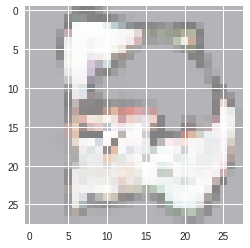

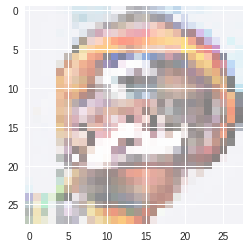

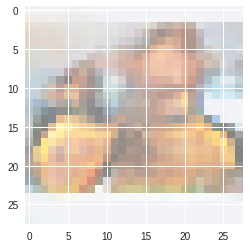

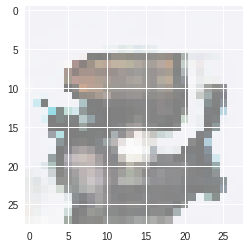

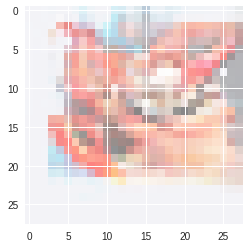

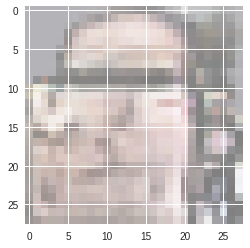

Epoch [25/50], Step [1/390], d_loss: -0.5036, g_loss: 1.4290, D(x): 2.09, D(G(z)): 1.59
Epoch [25/50], Step [2/390], d_loss: -0.8934, g_loss: -1.3232, D(x): -0.30, D(G(z)): -1.20
Epoch [25/50], Step [3/390], d_loss: -0.7664, g_loss: 1.5166, D(x): 2.44, D(G(z)): 1.67
Epoch [25/50], Step [4/390], d_loss: -1.9085, g_loss: 0.4977, D(x): 0.98, D(G(z)): -0.93
Epoch [25/50], Step [5/390], d_loss: -1.6792, g_loss: 2.6211, D(x): 1.68, D(G(z)): 0.00
Epoch [25/50], Step [6/390], d_loss: -1.0527, g_loss: -0.3474, D(x): -1.50, D(G(z)): -2.55
Epoch [25/50], Step [7/390], d_loss: -0.9025, g_loss: 1.0192, D(x): 1.68, D(G(z)): 0.78
Epoch [25/50], Step [8/390], d_loss: -0.9641, g_loss: 0.2860, D(x): 0.17, D(G(z)): -0.80
Epoch [25/50], Step [9/390], d_loss: -0.9245, g_loss: 1.4240, D(x): 1.14, D(G(z)): 0.21
Epoch [25/50], Step [10/390], d_loss: -0.0091, g_loss: 0.9787, D(x): -0.62, D(G(z)): -0.63
Epoch [25/50], Step [11/390], d_loss: -0.5462, g_loss: -0.5970, D(x): 0.04, D(G(z)): -0.51
Epoch [25/50], Ste

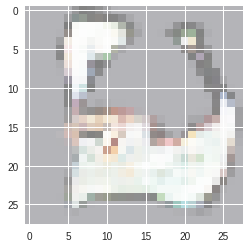

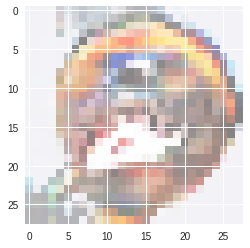

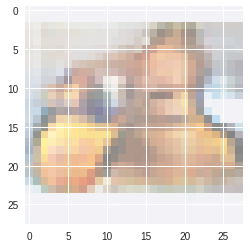

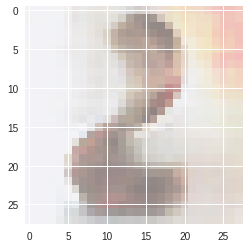

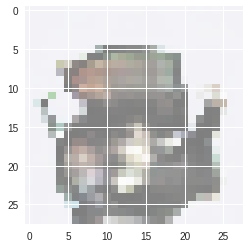

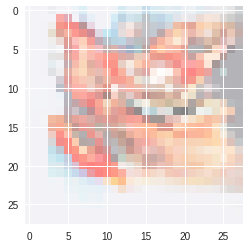

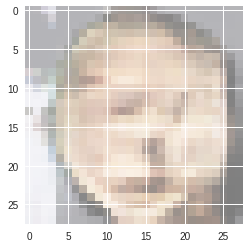

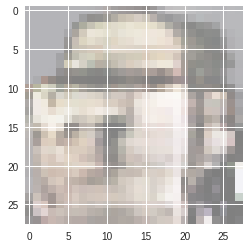

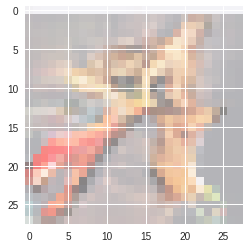

Epoch [26/50], Step [1/390], d_loss: -0.6872, g_loss: 2.5942, D(x): 1.56, D(G(z)): 0.87
Epoch [26/50], Step [2/390], d_loss: -0.5511, g_loss: -0.6436, D(x): -1.76, D(G(z)): -2.31
Epoch [26/50], Step [3/390], d_loss: -0.6207, g_loss: 1.5245, D(x): 1.89, D(G(z)): 1.27
Epoch [26/50], Step [4/390], d_loss: -1.7284, g_loss: -0.7317, D(x): 0.62, D(G(z)): -1.10
Epoch [26/50], Step [5/390], d_loss: -1.1338, g_loss: 1.5292, D(x): 2.33, D(G(z)): 1.19
Epoch [26/50], Step [6/390], d_loss: -1.3914, g_loss: -0.1133, D(x): -0.24, D(G(z)): -1.63
Epoch [26/50], Step [7/390], d_loss: -0.9866, g_loss: 1.5621, D(x): 1.59, D(G(z)): 0.61
Epoch [26/50], Step [8/390], d_loss: -0.8266, g_loss: -0.3670, D(x): -0.46, D(G(z)): -1.28
Epoch [26/50], Step [9/390], d_loss: -0.7360, g_loss: 1.6542, D(x): 1.50, D(G(z)): 0.76
Epoch [26/50], Step [10/390], d_loss: -0.1285, g_loss: 0.3367, D(x): -0.81, D(G(z)): -0.93
Epoch [26/50], Step [11/390], d_loss: -0.3918, g_loss: 0.6516, D(x): 0.72, D(G(z)): 0.33
Epoch [26/50], St

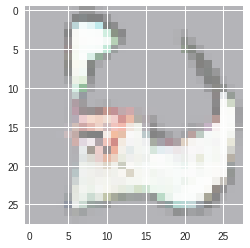

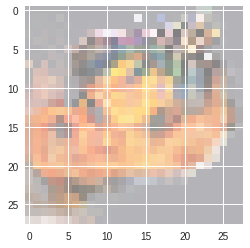

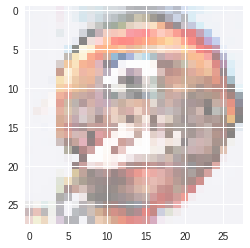

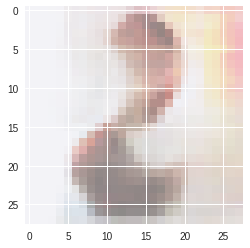

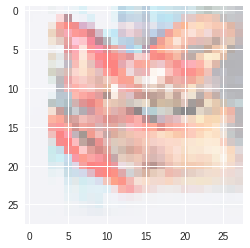

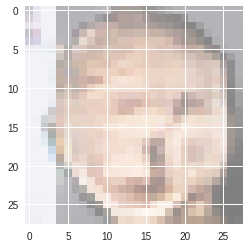

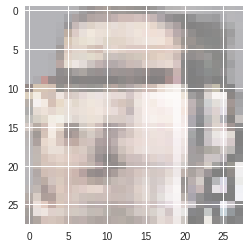

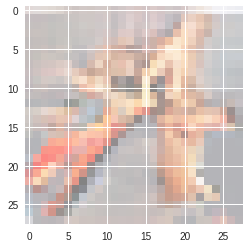

Epoch [27/50], Step [1/390], d_loss: -0.8550, g_loss: 2.7658, D(x): 1.64, D(G(z)): 0.78
Epoch [27/50], Step [2/390], d_loss: -0.4542, g_loss: -0.4340, D(x): -2.06, D(G(z)): -2.51
Epoch [27/50], Step [3/390], d_loss: -0.6189, g_loss: 0.9239, D(x): 1.54, D(G(z)): 0.92
Epoch [27/50], Step [4/390], d_loss: -1.7910, g_loss: 2.0867, D(x): 1.52, D(G(z)): -0.27
Epoch [27/50], Step [5/390], d_loss: -1.8274, g_loss: -0.9939, D(x): -0.10, D(G(z)): -1.93
Epoch [27/50], Step [6/390], d_loss: -0.8669, g_loss: 0.9205, D(x): 2.36, D(G(z)): 1.49
Epoch [27/50], Step [7/390], d_loss: -1.2347, g_loss: 0.6302, D(x): 0.44, D(G(z)): -0.79
Epoch [27/50], Step [8/390], d_loss: -0.6868, g_loss: 0.8563, D(x): 0.81, D(G(z)): 0.12
Epoch [27/50], Step [9/390], d_loss: -0.6576, g_loss: 0.5315, D(x): 0.37, D(G(z)): -0.29
Epoch [27/50], Step [10/390], d_loss: -0.2975, g_loss: 0.6255, D(x): 0.03, D(G(z)): -0.27
Epoch [27/50], Step [11/390], d_loss: -0.6370, g_loss: 1.1110, D(x): 0.70, D(G(z)): 0.06
Epoch [27/50], Step 

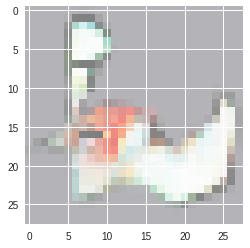

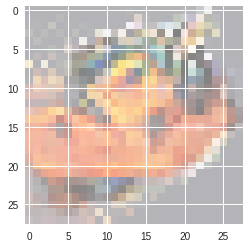

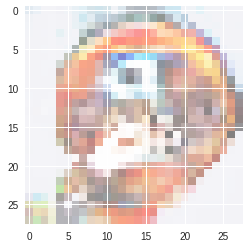

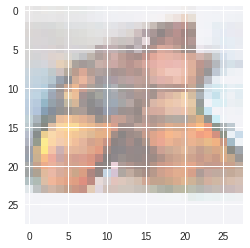

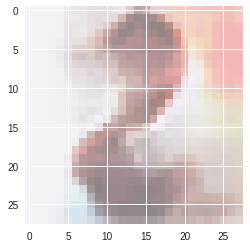

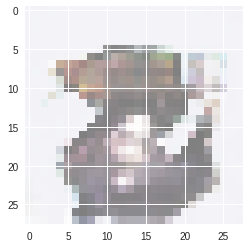

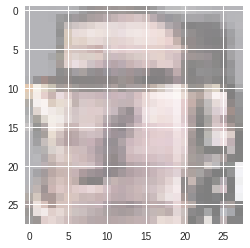

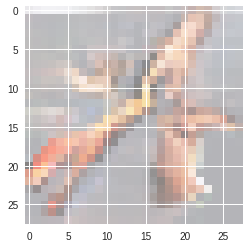

Epoch [28/50], Step [1/390], d_loss: -0.7256, g_loss: 1.9289, D(x): 1.10, D(G(z)): 0.38
Epoch [28/50], Step [2/390], d_loss: -0.5250, g_loss: -1.2272, D(x): -0.90, D(G(z)): -1.42
Epoch [28/50], Step [3/390], d_loss: -0.6491, g_loss: 1.0622, D(x): 2.32, D(G(z)): 1.67
Epoch [28/50], Step [4/390], d_loss: -1.6256, g_loss: 0.1291, D(x): 1.02, D(G(z)): -0.61
Epoch [28/50], Step [5/390], d_loss: -1.6651, g_loss: 2.6286, D(x): 1.80, D(G(z)): 0.13
Epoch [28/50], Step [6/390], d_loss: -1.0783, g_loss: -0.7534, D(x): -1.50, D(G(z)): -2.58
Epoch [28/50], Step [7/390], d_loss: -0.9151, g_loss: 1.1484, D(x): 2.02, D(G(z)): 1.11
Epoch [28/50], Step [8/390], d_loss: -0.7329, g_loss: -0.0183, D(x): -0.06, D(G(z)): -0.79
Epoch [28/50], Step [9/390], d_loss: -0.6778, g_loss: 1.1878, D(x): 1.08, D(G(z)): 0.40
Epoch [28/50], Step [10/390], d_loss: -0.1583, g_loss: 0.8122, D(x): -0.47, D(G(z)): -0.63
Epoch [28/50], Step [11/390], d_loss: -0.6250, g_loss: -0.1589, D(x): 0.30, D(G(z)): -0.33
Epoch [28/50], S

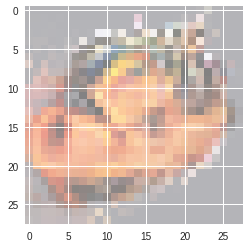

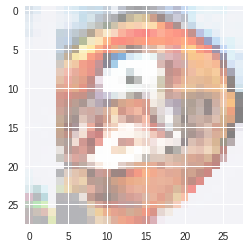

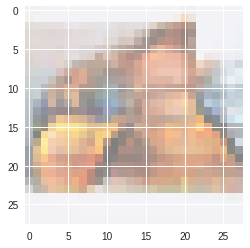

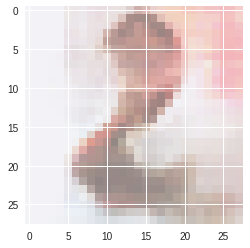

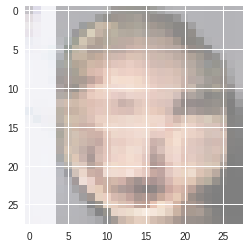

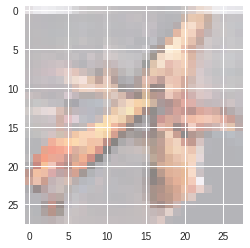

Epoch [29/50], Step [1/390], d_loss: -0.6298, g_loss: 0.4546, D(x): 0.28, D(G(z)): -0.35
Epoch [29/50], Step [2/390], d_loss: -0.6877, g_loss: 1.8905, D(x): 0.76, D(G(z)): 0.07
Epoch [29/50], Step [3/390], d_loss: -0.7420, g_loss: -2.1186, D(x): -0.61, D(G(z)): -1.35
Epoch [29/50], Step [4/390], d_loss: -0.8433, g_loss: 0.6236, D(x): 3.25, D(G(z)): 2.41
Epoch [29/50], Step [5/390], d_loss: -1.5284, g_loss: 1.1902, D(x): 0.96, D(G(z)): -0.57
Epoch [29/50], Step [6/390], d_loss: -1.4033, g_loss: -0.2673, D(x): 0.54, D(G(z)): -0.86
Epoch [29/50], Step [7/390], d_loss: -0.9197, g_loss: 2.0000, D(x): 1.72, D(G(z)): 0.80
Epoch [29/50], Step [8/390], d_loss: -0.9127, g_loss: -1.8753, D(x): -0.84, D(G(z)): -1.75
Epoch [29/50], Step [9/390], d_loss: -0.5197, g_loss: 0.1558, D(x): 2.64, D(G(z)): 2.12
Epoch [29/50], Step [10/390], d_loss: -0.2177, g_loss: 0.3488, D(x): 0.53, D(G(z)): 0.31
Epoch [29/50], Step [11/390], d_loss: -0.2746, g_loss: -0.3477, D(x): 0.64, D(G(z)): 0.36
Epoch [29/50], Step

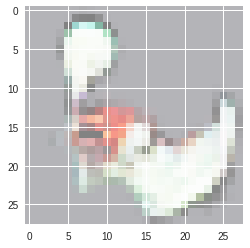

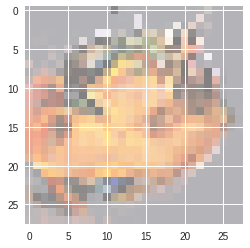

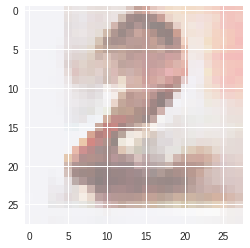

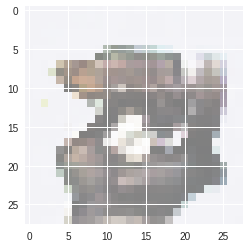

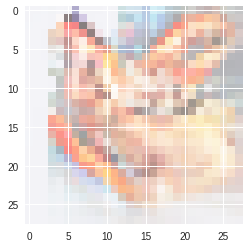

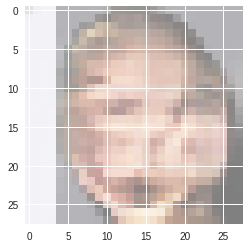

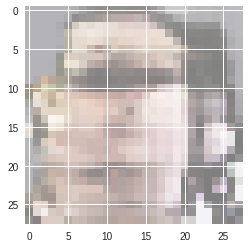

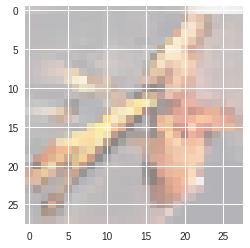

Epoch [30/50], Step [1/390], d_loss: -0.5977, g_loss: 0.9774, D(x): 0.67, D(G(z)): 0.07
Epoch [30/50], Step [2/390], d_loss: -0.4928, g_loss: 1.5798, D(x): 0.12, D(G(z)): -0.37
Epoch [30/50], Step [3/390], d_loss: -0.6331, g_loss: -1.6248, D(x): -0.27, D(G(z)): -0.90
Epoch [30/50], Step [4/390], d_loss: -0.9472, g_loss: 1.4157, D(x): 2.93, D(G(z)): 1.99
Epoch [30/50], Step [5/390], d_loss: -1.3881, g_loss: 0.4145, D(x): 0.11, D(G(z)): -1.28
Epoch [30/50], Step [6/390], d_loss: -1.1153, g_loss: 1.7411, D(x): 1.26, D(G(z)): 0.15
Epoch [30/50], Step [7/390], d_loss: -1.0825, g_loss: -0.8088, D(x): -0.41, D(G(z)): -1.49
Epoch [30/50], Step [8/390], d_loss: -0.7513, g_loss: 0.9649, D(x): 1.82, D(G(z)): 1.07
Epoch [30/50], Step [9/390], d_loss: -0.8410, g_loss: 0.8412, D(x): 0.41, D(G(z)): -0.43
Epoch [30/50], Step [10/390], d_loss: -0.1388, g_loss: 0.7374, D(x): -0.00, D(G(z)): -0.14
Epoch [30/50], Step [11/390], d_loss: -0.5858, g_loss: 0.5987, D(x): 0.39, D(G(z)): -0.19
Epoch [30/50], Ste

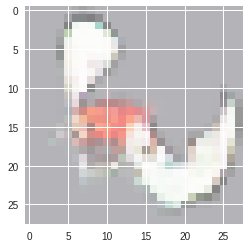

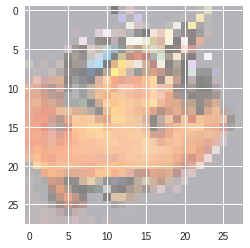

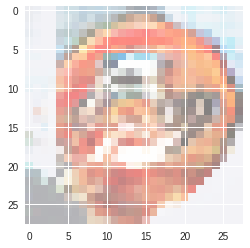

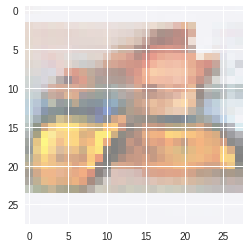

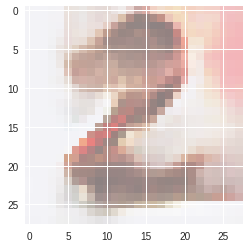

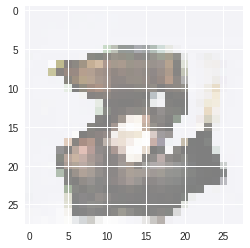

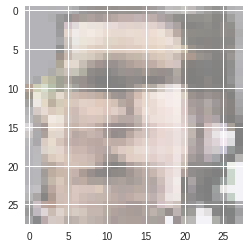

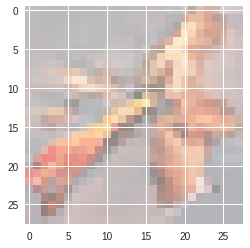

Epoch [31/50], Step [1/390], d_loss: -0.4232, g_loss: 1.2454, D(x): 1.57, D(G(z)): 1.15
Epoch [31/50], Step [2/390], d_loss: -0.5073, g_loss: 0.1394, D(x): -0.31, D(G(z)): -0.82
Epoch [31/50], Step [3/390], d_loss: -0.7642, g_loss: 0.3298, D(x): 1.21, D(G(z)): 0.44
Epoch [31/50], Step [4/390], d_loss: -1.9576, g_loss: 3.1375, D(x): 2.11, D(G(z)): 0.16
Epoch [31/50], Step [5/390], d_loss: -0.9872, g_loss: -0.4888, D(x): -1.99, D(G(z)): -2.98
Epoch [31/50], Step [6/390], d_loss: -1.1326, g_loss: 1.4609, D(x): 1.67, D(G(z)): 0.54
Epoch [31/50], Step [7/390], d_loss: -1.1500, g_loss: 0.2470, D(x): 0.05, D(G(z)): -1.10
Epoch [31/50], Step [8/390], d_loss: -0.9263, g_loss: 1.0733, D(x): 1.02, D(G(z)): 0.09
Epoch [31/50], Step [9/390], d_loss: -0.9292, g_loss: 0.9429, D(x): 0.34, D(G(z)): -0.59
Epoch [31/50], Step [10/390], d_loss: -0.1253, g_loss: 0.3392, D(x): -0.13, D(G(z)): -0.26
Epoch [31/50], Step [11/390], d_loss: -0.6403, g_loss: 1.1272, D(x): 0.85, D(G(z)): 0.21
Epoch [31/50], Step [

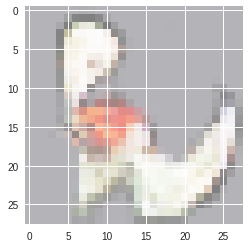

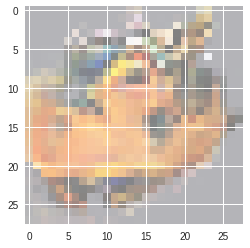

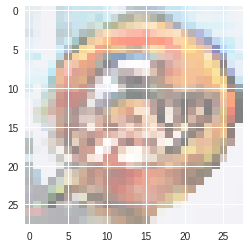

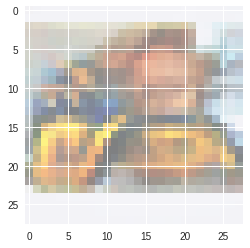

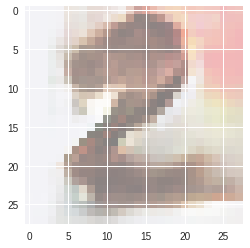

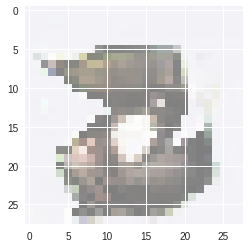

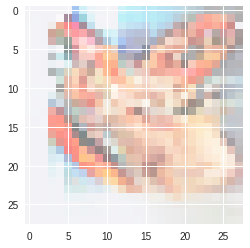

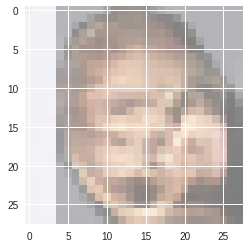

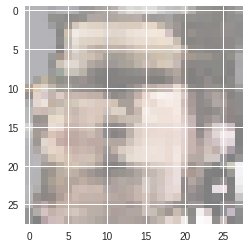

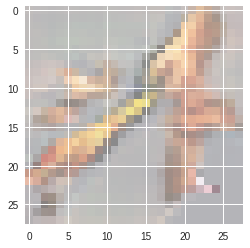

Epoch [32/50], Step [1/390], d_loss: -0.5442, g_loss: 1.7801, D(x): 1.34, D(G(z)): 0.80
Epoch [32/50], Step [2/390], d_loss: -0.6341, g_loss: -1.3179, D(x): -0.64, D(G(z)): -1.28
Epoch [32/50], Step [3/390], d_loss: -0.5542, g_loss: 1.0344, D(x): 2.29, D(G(z)): 1.74
Epoch [32/50], Step [4/390], d_loss: -1.8070, g_loss: 0.1200, D(x): 1.06, D(G(z)): -0.74
Epoch [32/50], Step [5/390], d_loss: -1.5830, g_loss: 2.3581, D(x): 1.84, D(G(z)): 0.25
Epoch [32/50], Step [6/390], d_loss: -1.1765, g_loss: -0.9932, D(x): -1.06, D(G(z)): -2.23
Epoch [32/50], Step [7/390], d_loss: -0.7198, g_loss: 0.3678, D(x): 2.14, D(G(z)): 1.42
Epoch [32/50], Step [8/390], d_loss: -0.7094, g_loss: 0.2830, D(x): 0.57, D(G(z)): -0.14
Epoch [32/50], Step [9/390], d_loss: -0.9039, g_loss: 1.3663, D(x): 0.96, D(G(z)): 0.06
Epoch [32/50], Step [10/390], d_loss: -0.2576, g_loss: 0.3939, D(x): -0.55, D(G(z)): -0.81
Epoch [32/50], Step [11/390], d_loss: -0.7550, g_loss: 1.3163, D(x): 0.91, D(G(z)): 0.15
Epoch [32/50], Step 

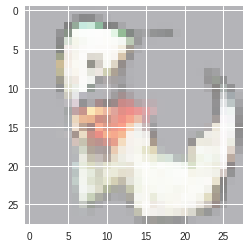

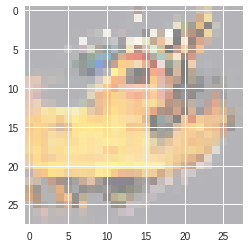

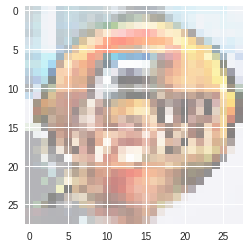

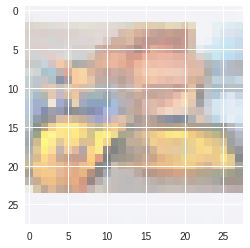

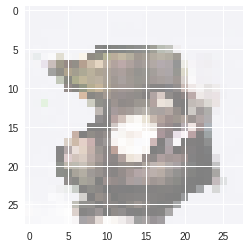

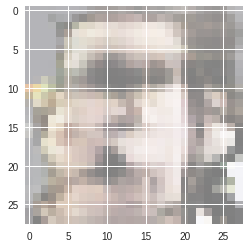

Epoch [33/50], Step [1/390], d_loss: -0.5428, g_loss: 0.0149, D(x): -0.41, D(G(z)): -0.96
Epoch [33/50], Step [2/390], d_loss: -0.7791, g_loss: 1.8897, D(x): 1.30, D(G(z)): 0.52
Epoch [33/50], Step [3/390], d_loss: -0.7185, g_loss: -2.1039, D(x): -0.75, D(G(z)): -1.47
Epoch [33/50], Step [4/390], d_loss: -0.9652, g_loss: 1.1002, D(x): 3.19, D(G(z)): 2.23
Epoch [33/50], Step [5/390], d_loss: -1.3080, g_loss: 0.6658, D(x): 0.62, D(G(z)): -0.69
Epoch [33/50], Step [6/390], d_loss: -1.2893, g_loss: 1.2353, D(x): 0.98, D(G(z)): -0.31
Epoch [33/50], Step [7/390], d_loss: -1.2988, g_loss: 0.1135, D(x): 0.42, D(G(z)): -0.88
Epoch [33/50], Step [8/390], d_loss: -0.6800, g_loss: 1.7054, D(x): 1.17, D(G(z)): 0.49
Epoch [33/50], Step [9/390], d_loss: -1.0827, g_loss: -1.3471, D(x): -0.26, D(G(z)): -1.35
Epoch [33/50], Step [10/390], d_loss: -0.3332, g_loss: -0.3090, D(x): 2.01, D(G(z)): 1.68
Epoch [33/50], Step [11/390], d_loss: -0.5841, g_loss: 1.1669, D(x): 1.45, D(G(z)): 0.87
Epoch [33/50], Ste

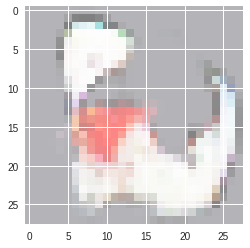

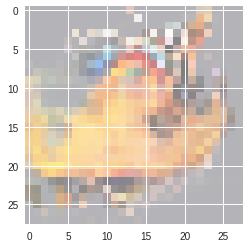

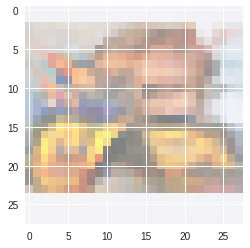

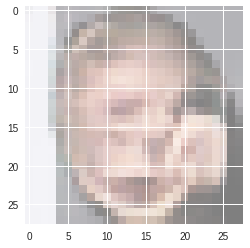

Epoch [34/50], Step [1/390], d_loss: -0.5142, g_loss: 1.9523, D(x): 1.47, D(G(z)): 0.95
Epoch [34/50], Step [2/390], d_loss: -0.6674, g_loss: -1.7821, D(x): -0.80, D(G(z)): -1.46
Epoch [34/50], Step [3/390], d_loss: -0.5677, g_loss: 0.8090, D(x): 2.76, D(G(z)): 2.19
Epoch [34/50], Step [4/390], d_loss: -1.7464, g_loss: 0.8744, D(x): 1.28, D(G(z)): -0.46
Epoch [34/50], Step [5/390], d_loss: -1.6005, g_loss: 2.1443, D(x): 1.39, D(G(z)): -0.21
Epoch [34/50], Step [6/390], d_loss: -1.2490, g_loss: -1.0434, D(x): -0.56, D(G(z)): -1.81
Epoch [34/50], Step [7/390], d_loss: -0.9004, g_loss: 1.5814, D(x): 2.13, D(G(z)): 1.23
Epoch [34/50], Step [8/390], d_loss: -0.7690, g_loss: -0.4546, D(x): -0.67, D(G(z)): -1.43
Epoch [34/50], Step [9/390], d_loss: -0.8354, g_loss: 1.5348, D(x): 1.52, D(G(z)): 0.68
Epoch [34/50], Step [10/390], d_loss: -0.3730, g_loss: 0.1100, D(x): -0.66, D(G(z)): -1.03
Epoch [34/50], Step [11/390], d_loss: -0.5293, g_loss: 1.7665, D(x): 1.13, D(G(z)): 0.61
Epoch [34/50], St

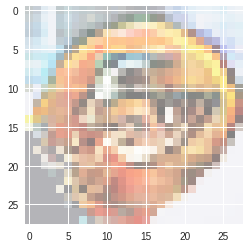

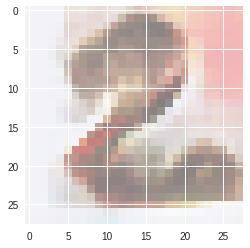

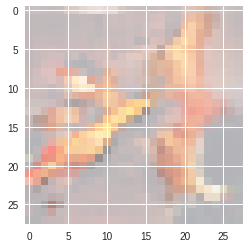

Epoch [35/50], Step [1/390], d_loss: -0.7090, g_loss: -0.7126, D(x): -0.52, D(G(z)): -1.23
Epoch [35/50], Step [2/390], d_loss: -0.6680, g_loss: 2.4029, D(x): 1.90, D(G(z)): 1.24
Epoch [35/50], Step [3/390], d_loss: -0.2924, g_loss: -0.6209, D(x): -1.73, D(G(z)): -2.02
Epoch [35/50], Step [4/390], d_loss: -1.4397, g_loss: 2.4812, D(x): 2.36, D(G(z)): 0.92
Epoch [35/50], Step [5/390], d_loss: -1.4376, g_loss: -0.6269, D(x): -0.94, D(G(z)): -2.37
Epoch [35/50], Step [6/390], d_loss: -1.0139, g_loss: 1.0813, D(x): 1.97, D(G(z)): 0.96
Epoch [35/50], Step [7/390], d_loss: -1.1315, g_loss: 0.7208, D(x): 0.29, D(G(z)): -0.85
Epoch [35/50], Step [8/390], d_loss: -0.8560, g_loss: 0.1253, D(x): 0.44, D(G(z)): -0.42
Epoch [35/50], Step [9/390], d_loss: -0.7295, g_loss: 1.3623, D(x): 1.14, D(G(z)): 0.41
Epoch [35/50], Step [10/390], d_loss: -0.0510, g_loss: 0.8835, D(x): -0.75, D(G(z)): -0.80
Epoch [35/50], Step [11/390], d_loss: -0.5500, g_loss: 0.5363, D(x): 0.16, D(G(z)): -0.39
Epoch [35/50], S

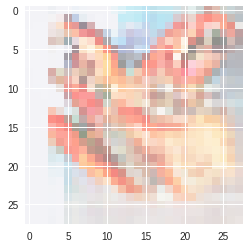

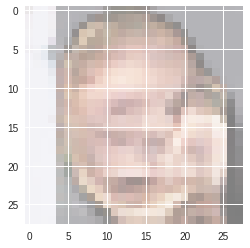

Epoch [36/50], Step [1/390], d_loss: -0.7891, g_loss: 2.8297, D(x): 1.99, D(G(z)): 1.20
Epoch [36/50], Step [2/390], d_loss: -0.3781, g_loss: 0.4258, D(x): -2.30, D(G(z)): -2.68
Epoch [36/50], Step [3/390], d_loss: -0.7412, g_loss: 0.3843, D(x): 0.78, D(G(z)): 0.04
Epoch [36/50], Step [4/390], d_loss: -1.6966, g_loss: 2.6119, D(x): 1.85, D(G(z)): 0.15
Epoch [36/50], Step [5/390], d_loss: -1.4054, g_loss: -0.7973, D(x): -1.09, D(G(z)): -2.49
Epoch [36/50], Step [6/390], d_loss: -1.0290, g_loss: 1.2096, D(x): 2.00, D(G(z)): 0.97
Epoch [36/50], Step [7/390], d_loss: -1.3325, g_loss: 0.6407, D(x): 0.23, D(G(z)): -1.11
Epoch [36/50], Step [8/390], d_loss: -0.9843, g_loss: 0.7118, D(x): 0.71, D(G(z)): -0.27
Epoch [36/50], Step [9/390], d_loss: -0.8780, g_loss: 1.1220, D(x): 0.66, D(G(z)): -0.22
Epoch [36/50], Step [10/390], d_loss: -0.2382, g_loss: 0.7644, D(x): -0.37, D(G(z)): -0.60
Epoch [36/50], Step [11/390], d_loss: -0.6241, g_loss: 1.4539, D(x): 0.59, D(G(z)): -0.03
Epoch [36/50], Step

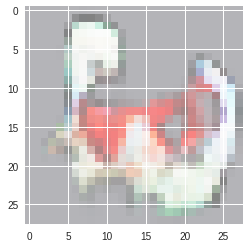

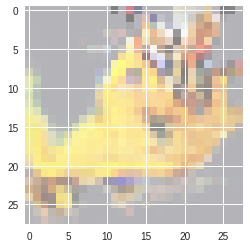

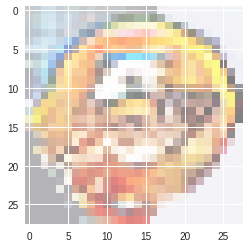

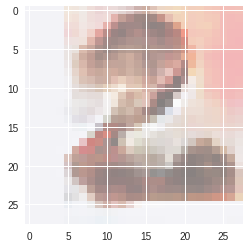

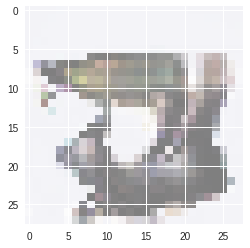

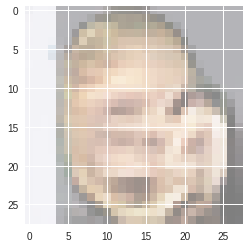

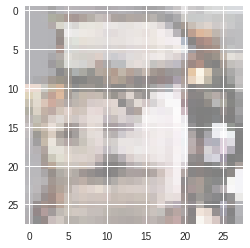

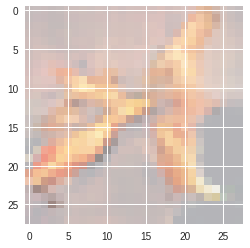

Epoch [37/50], Step [1/390], d_loss: -0.3446, g_loss: 1.0903, D(x): 2.36, D(G(z)): 2.02
Epoch [37/50], Step [2/390], d_loss: -0.4355, g_loss: -0.2818, D(x): -0.19, D(G(z)): -0.63
Epoch [37/50], Step [3/390], d_loss: -0.8645, g_loss: 1.5052, D(x): 1.60, D(G(z)): 0.73
Epoch [37/50], Step [4/390], d_loss: -2.0563, g_loss: 0.5681, D(x): 1.10, D(G(z)): -0.96
Epoch [37/50], Step [5/390], d_loss: -2.0523, g_loss: 2.8020, D(x): 1.67, D(G(z)): -0.39
Epoch [37/50], Step [6/390], d_loss: -0.8962, g_loss: -0.5509, D(x): -1.71, D(G(z)): -2.61
Epoch [37/50], Step [7/390], d_loss: -0.9091, g_loss: 1.0707, D(x): 1.77, D(G(z)): 0.86
Epoch [37/50], Step [8/390], d_loss: -0.6323, g_loss: -0.0420, D(x): -0.06, D(G(z)): -0.69
Epoch [37/50], Step [9/390], d_loss: -0.8958, g_loss: 1.1986, D(x): 1.01, D(G(z)): 0.12
Epoch [37/50], Step [10/390], d_loss: -0.2263, g_loss: 0.2175, D(x): -0.41, D(G(z)): -0.64
Epoch [37/50], Step [11/390], d_loss: -0.4102, g_loss: 0.3730, D(x): 0.93, D(G(z)): 0.52
Epoch [37/50], St

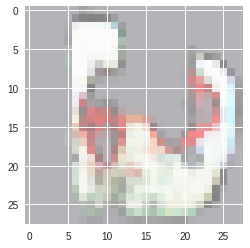

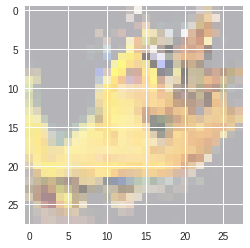

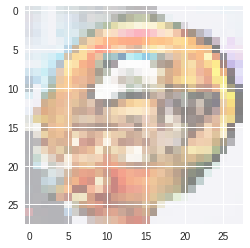

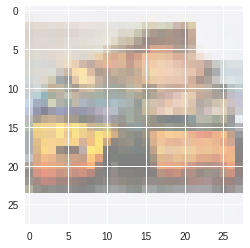

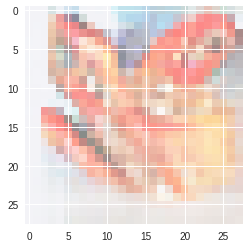

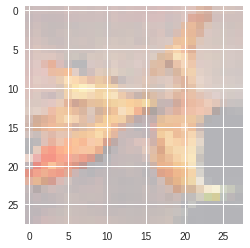

Epoch [38/50], Step [1/390], d_loss: -0.6253, g_loss: 0.7177, D(x): 0.34, D(G(z)): -0.29
Epoch [38/50], Step [2/390], d_loss: -0.6399, g_loss: 1.2639, D(x): 0.49, D(G(z)): -0.15
Epoch [38/50], Step [3/390], d_loss: -0.8209, g_loss: -1.4198, D(x): 0.19, D(G(z)): -0.64
Epoch [38/50], Step [4/390], d_loss: -1.1984, g_loss: 2.4754, D(x): 2.99, D(G(z)): 1.79
Epoch [38/50], Step [5/390], d_loss: -1.1085, g_loss: -0.3062, D(x): -1.20, D(G(z)): -2.31
Epoch [38/50], Step [6/390], d_loss: -1.1608, g_loss: 1.4849, D(x): 1.68, D(G(z)): 0.51
Epoch [38/50], Step [7/390], d_loss: -1.2198, g_loss: -0.0169, D(x): -0.02, D(G(z)): -1.24
Epoch [38/50], Step [8/390], d_loss: -0.9449, g_loss: 1.6434, D(x): 1.39, D(G(z)): 0.45
Epoch [38/50], Step [9/390], d_loss: -0.8649, g_loss: -0.5561, D(x): -0.24, D(G(z)): -1.11
Epoch [38/50], Step [10/390], d_loss: -0.2776, g_loss: 0.6153, D(x): 1.28, D(G(z)): 1.01
Epoch [38/50], Step [11/390], d_loss: -0.4178, g_loss: 0.4303, D(x): 0.62, D(G(z)): 0.20
Epoch [38/50], St

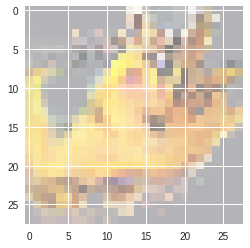

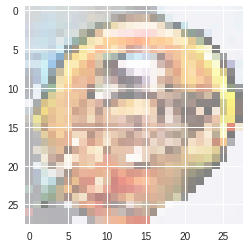

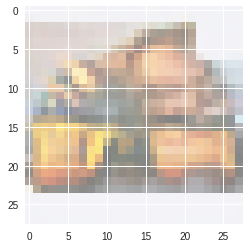

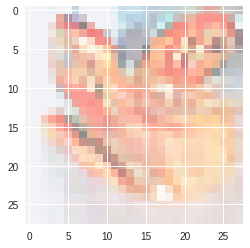

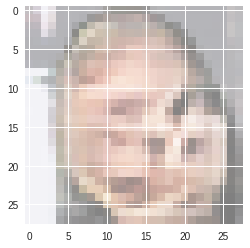

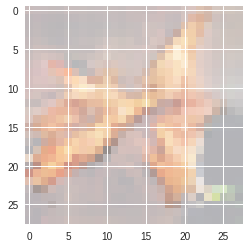

Epoch [39/50], Step [1/390], d_loss: -0.7334, g_loss: 2.5590, D(x): 1.33, D(G(z)): 0.59
Epoch [39/50], Step [2/390], d_loss: -0.4667, g_loss: -1.3087, D(x): -1.83, D(G(z)): -2.30
Epoch [39/50], Step [3/390], d_loss: -0.3958, g_loss: 0.2526, D(x): 2.10, D(G(z)): 1.70
Epoch [39/50], Step [4/390], d_loss: -1.7462, g_loss: 2.5506, D(x): 1.94, D(G(z)): 0.20
Epoch [39/50], Step [5/390], d_loss: -1.5539, g_loss: -1.4151, D(x): -0.89, D(G(z)): -2.44
Epoch [39/50], Step [6/390], d_loss: -0.9137, g_loss: 0.7375, D(x): 2.57, D(G(z)): 1.66
Epoch [39/50], Step [7/390], d_loss: -1.1268, g_loss: 0.7732, D(x): 0.69, D(G(z)): -0.43
Epoch [39/50], Step [8/390], d_loss: -0.8075, g_loss: 0.7068, D(x): 0.45, D(G(z)): -0.35
Epoch [39/50], Step [9/390], d_loss: -0.8377, g_loss: 0.8570, D(x): 0.54, D(G(z)): -0.30
Epoch [39/50], Step [10/390], d_loss: -0.1045, g_loss: 0.6881, D(x): -0.13, D(G(z)): -0.23
Epoch [39/50], Step [11/390], d_loss: -0.6794, g_loss: 0.8934, D(x): 0.53, D(G(z)): -0.14
Epoch [39/50], Ste

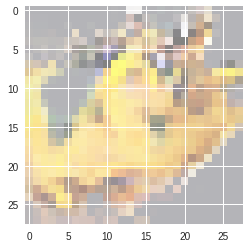

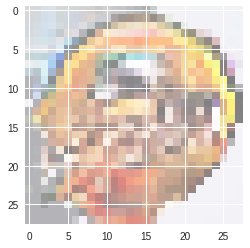

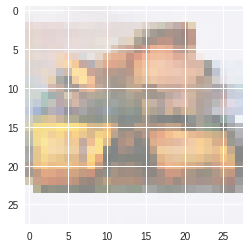

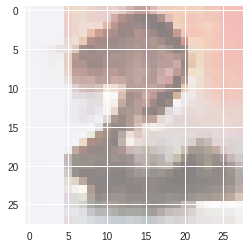

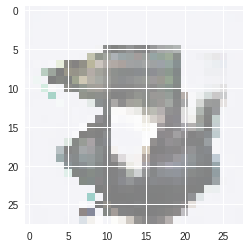

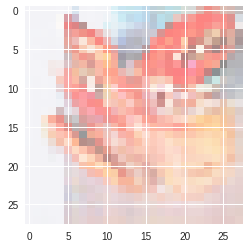

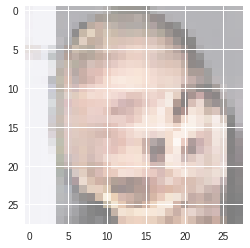

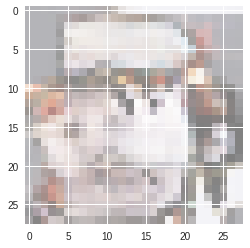

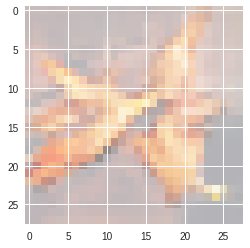

Epoch [40/50], Step [1/390], d_loss: -0.6369, g_loss: 2.5430, D(x): 1.69, D(G(z)): 1.05
Epoch [40/50], Step [2/390], d_loss: -0.5404, g_loss: -1.2950, D(x): -1.82, D(G(z)): -2.36
Epoch [40/50], Step [3/390], d_loss: -0.4694, g_loss: 0.6895, D(x): 2.23, D(G(z)): 1.76
Epoch [40/50], Step [4/390], d_loss: -1.8172, g_loss: 1.5041, D(x): 1.48, D(G(z)): -0.34
Epoch [40/50], Step [5/390], d_loss: -2.1291, g_loss: 0.8022, D(x): 0.91, D(G(z)): -1.22
Epoch [40/50], Step [6/390], d_loss: -1.6136, g_loss: 2.7107, D(x): 1.32, D(G(z)): -0.29
Epoch [40/50], Step [7/390], d_loss: -1.1138, g_loss: -1.9233, D(x): -1.41, D(G(z)): -2.52
Epoch [40/50], Step [8/390], d_loss: -0.4895, g_loss: -0.6312, D(x): 2.69, D(G(z)): 2.20
Epoch [40/50], Step [9/390], d_loss: -0.5922, g_loss: 0.3640, D(x): 1.62, D(G(z)): 1.02
Epoch [40/50], Step [10/390], d_loss: -0.3774, g_loss: 0.3709, D(x): 0.24, D(G(z)): -0.14
Epoch [40/50], Step [11/390], d_loss: -0.5476, g_loss: 0.3113, D(x): 0.82, D(G(z)): 0.27
Epoch [40/50], Step

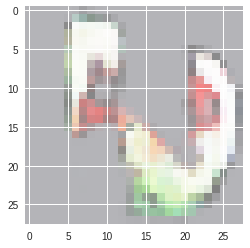

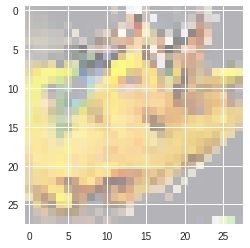

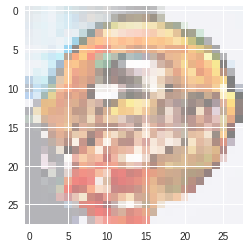

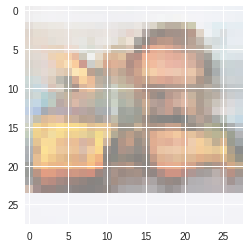

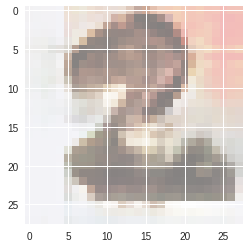

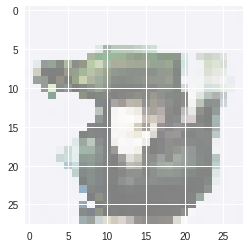

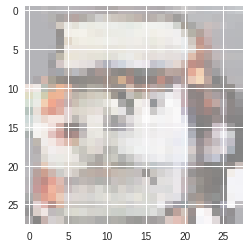

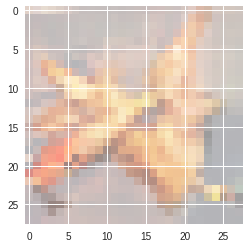

Epoch [41/50], Step [1/390], d_loss: -0.6839, g_loss: 2.2869, D(x): 1.48, D(G(z)): 0.80
Epoch [41/50], Step [2/390], d_loss: -0.3559, g_loss: -0.3697, D(x): -1.51, D(G(z)): -1.87
Epoch [41/50], Step [3/390], d_loss: -0.6371, g_loss: 0.6215, D(x): 1.43, D(G(z)): 0.80
Epoch [41/50], Step [4/390], d_loss: -1.8596, g_loss: 2.3549, D(x): 1.64, D(G(z)): -0.22
Epoch [41/50], Step [5/390], d_loss: -1.7639, g_loss: -1.2633, D(x): -0.26, D(G(z)): -2.02
Epoch [41/50], Step [6/390], d_loss: -1.0198, g_loss: 1.7231, D(x): 2.47, D(G(z)): 1.45
Epoch [41/50], Step [7/390], d_loss: -1.0558, g_loss: 0.3227, D(x): -0.41, D(G(z)): -1.46
Epoch [41/50], Step [8/390], d_loss: -0.7950, g_loss: 0.7625, D(x): 0.85, D(G(z)): 0.05
Epoch [41/50], Step [9/390], d_loss: -0.8640, g_loss: 1.3775, D(x): 0.63, D(G(z)): -0.24
Epoch [41/50], Step [10/390], d_loss: -0.2590, g_loss: 0.7632, D(x): -0.52, D(G(z)): -0.78
Epoch [41/50], Step [11/390], d_loss: -0.5287, g_loss: 1.0797, D(x): 0.41, D(G(z)): -0.12
Epoch [41/50], St

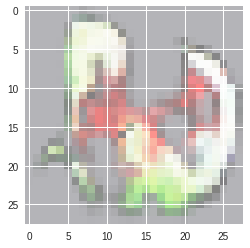

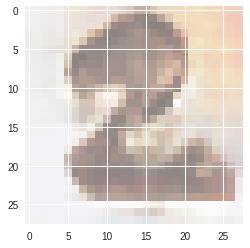

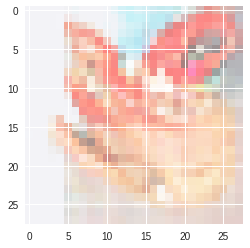

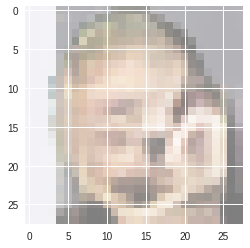

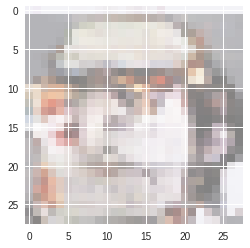

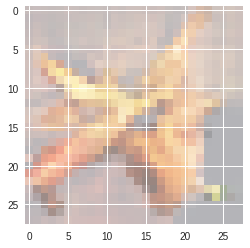

Epoch [42/50], Step [1/390], d_loss: -0.7270, g_loss: -1.5687, D(x): -0.53, D(G(z)): -1.26
Epoch [42/50], Step [2/390], d_loss: -0.4321, g_loss: 2.1014, D(x): 2.44, D(G(z)): 2.00
Epoch [42/50], Step [3/390], d_loss: -0.5368, g_loss: -1.8667, D(x): -1.33, D(G(z)): -1.86
Epoch [42/50], Step [4/390], d_loss: -0.9772, g_loss: 1.6014, D(x): 3.13, D(G(z)): 2.15
Epoch [42/50], Step [5/390], d_loss: -1.7121, g_loss: -0.0908, D(x): 0.12, D(G(z)): -1.60
Epoch [42/50], Step [6/390], d_loss: -1.3169, g_loss: 1.9896, D(x): 1.83, D(G(z)): 0.51
Epoch [42/50], Step [7/390], d_loss: -1.1220, g_loss: -0.8679, D(x): -0.59, D(G(z)): -1.72
Epoch [42/50], Step [8/390], d_loss: -0.7023, g_loss: 1.1417, D(x): 1.89, D(G(z)): 1.19
Epoch [42/50], Step [9/390], d_loss: -0.8461, g_loss: 0.5664, D(x): 0.07, D(G(z)): -0.78
Epoch [42/50], Step [10/390], d_loss: -0.2667, g_loss: 1.2306, D(x): 0.17, D(G(z)): -0.10
Epoch [42/50], Step [11/390], d_loss: -0.6654, g_loss: 0.2242, D(x): 0.10, D(G(z)): -0.57
Epoch [42/50], S

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

G.apply(weights_init)
D.apply(weights_init)


num_epochs = 50

batch_size = 128

criterion = nn.BCELoss()

# Create the labels which are later used as input for the BCE loss
real_labels = torch.ones((batch_size, 1, 1, 1), device=device)
fake_labels = torch.zeros((batch_size, 1, 1, 1), device=device)
fixed_noise = torch.randn(batch_size, *latent_shape).to(device)



# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        D.zero_grad()
        
        #outputs = D(images)
        #d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(noise)
        
        D_real = torch.mean(D(images))
        D_fake = torch.mean(D(fake_images.detach()))
        
        d_loss = -(D_real - D_fake)

        #real_score = outputs.mean().item()
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        
        #outputs = D(fake_images.detach()) # Don't make a gradient update through G yet
        #d_loss_fake = criterion(outputs, fake_labels)
        #fake_score = outputs.mean().item()
        
        # Backprop and optimize
        #d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Compute loss with fake images
        G.zero_grad()
        
        D_fake_images = D(fake_images)
                
        g_loss = -torch.mean(D_fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        #g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          D_real.item(), D_fake.item()))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    #torch.save(G.state_dict(), 'G.ckpt')
    #torch.save(D.state_dict(), 'D.ckpt')
    
    # Save sampled images
    for image in denorm(G(fixed_noise)).cpu().detach()[:10]:
        plt.figure()
        plt.imshow(tensor2plt(image))
        plt.show()
